In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Define the Pose Estimation Model
class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class ObjectDatasetByID(Dataset):
    def __init__(self, data_2d_path, data_3d_path):
        self.data_by_id = defaultdict(lambda: {"2d": [], "3d": []})
        self.expected_output_size = 31  # Expected output size based on structure

        files_2d = sorted([f for f in os.listdir(data_2d_path) if f.endswith('.csv')])
        
        for file_2d in files_2d:
            data_2d_file_path = os.path.join(data_2d_path, file_2d)
            data_3d_file_path = os.path.join(data_3d_path, file_2d)

            if not os.path.exists(data_3d_file_path):
                print(f"Skipping; 3D file missing for: {file_2d}")
                continue

            try:
                df_2d = pd.read_csv(data_2d_file_path, header=None)
                df_3d = pd.read_csv(data_3d_file_path, header=None)

                if len(df_2d) != len(df_3d):
                    print(f"Skipping; row count mismatch in files: {file_2d}")
                    continue
                if df_3d.shape[1] != self.expected_output_size:
                    print(f"Skipping; 3D data size mismatch for file {file_2d}")
                    continue

                for row_2d, row_3d in zip(df_2d.values, df_3d.values):
                    obj_id = int(row_2d[0])  # First column is the ID
                    self.data_by_id[obj_id]["2d"].append(torch.tensor(row_2d[1:], dtype=torch.float32)) 
                    self.data_by_id[obj_id]["3d"].append(torch.tensor(row_3d[1:], dtype=torch.float32))

            except (pd.errors.EmptyDataError, ValueError):
                print(f"Skipping invalid file pair: {file_2d}")

    def get_data_by_id(self):
        # Returns the data separated by ID
        return {obj_id: (torch.stack(data["2d"]), torch.stack(data["3d"]))
                for obj_id, data in self.data_by_id.items()}


In [2]:
import torch.optim as optim
import time

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(data_loader)

# Training function with early stopping
def train_model_for_id(
    model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=10, patience=5, device='cpu', obj_id=None
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    print(f"\n{'='*50}")
    print(f"Training Start for ID {obj_id}")
    print(f"{'='*50}\n")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Handle single-sample batches
            if inputs.size(0) < 2:
                print("Switching to eval mode for single-sample batch.")
                model.eval()  # Use eval mode for BatchNorm1d
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                model.train()  # Switch back to train mode
                continue

            # Normal training process for batches with sufficient samples
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)

        print(f"ID: {obj_id} - Epoch [{epoch+1}/{num_epochs}] - "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping and model saving logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"sye{obj_id}.pth")
            print(f"Validation loss improved. Model for ID {obj_id} saved.")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epochs.")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered for ID {obj_id} after {epoch+1} epochs.")
            break


In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

base_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data"
dataset_name = "8_correct_relative"
data_2d_subfolder = "2d_data"
data_3d_subfolder = "3d_data"

# Construct paths to the data directories
data_2d_path = os.path.join(base_path, dataset_name, data_2d_subfolder)
data_3d_path = os.path.join(base_path, dataset_name, data_3d_subfolder)

# Load the dataset and get data by ID
object_dataset_by_id = ObjectDatasetByID(data_2d_path, data_3d_path)
data_by_id = object_dataset_by_id.get_data_by_id()

# Model parameters
input_size = 20
output_size = 30
learning_rate = 0.001
num_epochs = 50
patience = 5  # Early stopping patience

# Loss function
criterion = nn.MSELoss()

# Loop through each unique ID to train and save models
for obj_id, (data_2d, data_3d) in data_by_id.items():
    dataset = torch.utils.data.TensorDataset(data_2d, data_3d)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    if train_size == 0 or val_size == 0:
        print(f"Skipping ID {obj_id} due to insufficient data.")
        continue

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nStarting training for ID {obj_id}")
    train_model_for_id(
        model, train_loader, val_loader, criterion, optimizer, 
        num_epochs=num_epochs, patience=patience, device='cpu', obj_id=obj_id
    )


KeyboardInterrupt: 

In [9]:
import torch
import pandas as pd
import os

base_path = r"C:\Users\sakar\OneDrive\mt-datas\yolo\pose_estimation"
filename = "1_realistic_chair_train_2_yolo_result.csv"

# Construct paths to the data directories
data_2d_sample_path = os.path.join(base_path, filename)

# Define the function to load the trained model and use it for inference
def load_model_and_predict_3d(data_2d_path, model_path="sye0.pth", input_size=20, output_size=30):
    # Instantiate the model architecture and load weights
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # Added `weights_only=True`
    model.eval()  # Set the model to evaluation mode

    # Load the 2D data for inference
    try:
        df_2d = pd.read_csv(data_2d_path, header=None)
        df_2d = df_2d.iloc[:, 1:]  # Drop the ID column
        data_2d_tensor = torch.tensor(df_2d.values, dtype=torch.float32)
    except Exception as e:
        print(f"Error loading or processing 2D data: {e}")
        return None

    # Run the model to predict 3D points
    with torch.no_grad():
        predictions_3d = model(data_2d_tensor)
        
    return predictions_3d

predictions_3d = load_model_and_predict_3d(data_2d_sample_path)

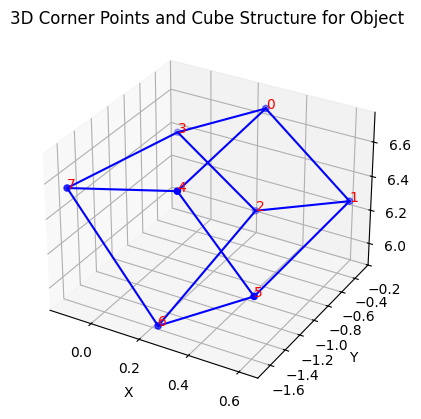

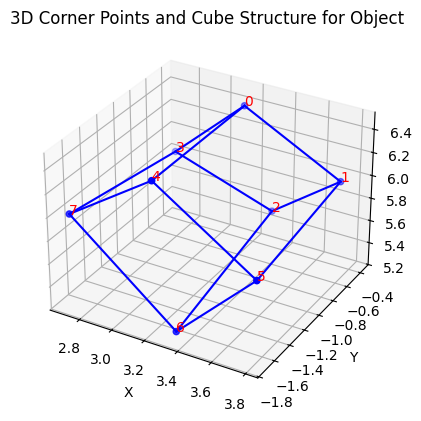

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot 3D corner points from predictions and connect them to form a cube
def plot_3d_corners(predictions_3d):
    # Check if predictions are available
    if predictions_3d is None:
        print("No predictions to plot.")
        return
    
    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    # Plot each object’s corners in a 3D space
    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Coordinates of the corners
        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        # Annotate each corner for clarity
        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j}", color="red")

        # Define connections for the cube
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom square
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top square
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges connecting squares
        ]

        # Plot lines for each connection
        for start, end in connections:
            ax.plot(
                [x[start], x[end]],
                [y[start], y[end]],
                [z[start], z[end]],
                'b-'
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points and Cube Structure for Object")
        plt.show()

# Plot the 3D corners from the predictions
plot_3d_corners(predictions_3d)


In [11]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import torch


def compute_euclidean_distance_3d(pred_row, gt_row):
    """
    Computes the Euclidean distance between 3D positions of predictions and ground truth.
    """
    pred_position = pred_row[:3]
    gt_position = gt_row[:3]
    return euclidean(pred_position, gt_position)


def compute_corner_distances(pred_row, gt_row):
    """
    Computes average Euclidean distance between corners of predicted and ground truth bounding boxes.
    """
    try:
        pred_corners = np.array(pred_row[6:]).reshape(-1, 3)
        gt_corners = np.array(gt_row[6:]).reshape(-1, 3)

        if len(pred_corners) != len(gt_corners):
            print("Mismatch in the number of corners. Skipping this comparison.")
            return np.nan

        distances = [euclidean(pred_corners[i], gt_corners[i]) for i in range(len(pred_corners))]
        return np.mean(distances)
    except ValueError as e:
        print(f"Error in computing corner distances: {e}")
        return np.nan


def find_closest_match_3d(predictions, ground_truth):
    """
    Finds the closest match for each prediction in the ground truth based on Euclidean distance.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    gt_groups = ground_truth.groupby(0)
    pred_groups = predictions.groupby(0)

    # Get the intersection of IDs present in both predictions and ground truth
    common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

    for obj_id in common_ids:
        gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
        pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

        # Match predictions and ground truth for this object ID
        while not gt_rows.empty and not pred_rows.empty:
            min_distance = None
            min_corner_distance = None
            min_gt_index = None
            min_pred_index = None

            for gt_index, gt_row in gt_rows.iterrows():
                for pred_index, pred_row in pred_rows.iterrows():
                    position_distance = compute_euclidean_distance_3d(pred_row[1:], gt_row[1:])
                    corner_distance = compute_corner_distances(pred_row[1:], gt_row[1:])

                    if min_distance is None or position_distance < min_distance:
                        min_distance = position_distance
                        min_corner_distance = corner_distance
                        min_gt_index = gt_index
                        min_pred_index = pred_index

            results.append({
                "id": obj_id,
                "min_position_distance": min_distance,
                "min_corner_distance": min_corner_distance,
            })

            gt_rows.drop(index=min_gt_index, inplace=True)
            pred_rows.drop(index=min_pred_index, inplace=True)

    return results


ddef process_all_files_3d(base_path_2d, base_path_3d):
    """
    Process all 2D files to predict 3D data and compare with ground truth 3D data.
    """
    all_results = []
    file_list = [file_name for file_name in os.listdir(base_path_2d) if file_name.endswith(".csv")]

    # Take only the first 10 files for testing
    file_list = file_list[:10]
    total_files = len(file_list)

    for idx, file_name in enumerate(file_list):
        print(f"Processing file {idx + 1}/{total_files} ({((idx + 1) / total_files) * 100:.2f}%) - {file_name}")

        file_2d_path = os.path.join(base_path_2d, file_name)
        file_3d_path = os.path.join(base_path_3d, file_name)

        if not os.path.exists(file_3d_path):
            print(f"3D data file for {file_name} not found. Skipping.")
            continue

        try:
            # Load 2D data
            df_2d = pd.read_csv(file_2d_path, header=None)

            # Extract IDs from the first column
            ids_2d = df_2d.iloc[:, 0].values

            # Predict 3D data
            predicted_3d = load_model_and_predict_3d(file_2d_path)
            if predicted_3d is None:
                print(f"Prediction failed for {file_name}. Skipping.")
                continue

            # Convert predictions to DataFrame and add IDs
            predicted_3d_df = pd.DataFrame(predicted_3d.numpy(), columns=[i for i in range(predicted_3d.shape[1])])
            predicted_3d_df.insert(0, 'ID', ids_2d)  # Add IDs from 2D data

            # Load ground truth 3D data
            actual_3d_df = pd.read_csv(file_3d_path, header=None)

            # Check for correct number of columns
            if actual_3d_df.shape[1] != 31:
                print(f"Incorrect number of columns in 3D data for {file_name}. Expected 31, got {actual_3d_df.shape[1]}. Skipping.")
                continue

            # Find closest matches
            results = find_closest_match_3d(predicted_3d_df, actual_3d_df)

            # Store results for the file
            file_results = {"file": file_name, "objects": results}
            all_results.append(file_results)

        except Exception as e:
            print(f"Error loading or processing 3D data for {file_name}: {e}")
            continue

    return all_results


# Directories for 2D and 3D data
base_path_2d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\2d_data"
base_path_3d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\3d_data"

# Process files and collect results
results = process_all_files_3d(base_path_2d, base_path_3d)

# Example output
print("Euclidean Distance Results:")
for file_result in results:
    print(file_result)


Processing file 1/10 (10.00%) - 0.csv
Error loading or processing 3D data for 0.csv: cannot insert 0, already exists
Processing file 2/10 (20.00%) - 1.csv
Error loading or processing 3D data for 1.csv: cannot insert 0, already exists
Processing file 3/10 (30.00%) - 10.csv
Error loading or processing 3D data for 10.csv: cannot insert 0, already exists
Processing file 4/10 (40.00%) - 100.csv
Error loading or processing 3D data for 100.csv: cannot insert 0, already exists
Processing file 5/10 (50.00%) - 1000.csv
Error loading or processing 3D data for 1000.csv: cannot insert 0, already exists
Processing file 6/10 (60.00%) - 1001.csv
Error loading or processing 3D data for 1001.csv: cannot insert 0, already exists
Processing file 7/10 (70.00%) - 1002.csv
Error loading or processing 3D data for 1002.csv: cannot insert 0, already exists
Processing file 8/10 (80.00%) - 1003.csv
Error loading or processing 3D data for 1003.csv: cannot insert 0, already exists
Processing file 9/10 (90.00%) - 10

c:\Users\sakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sakar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


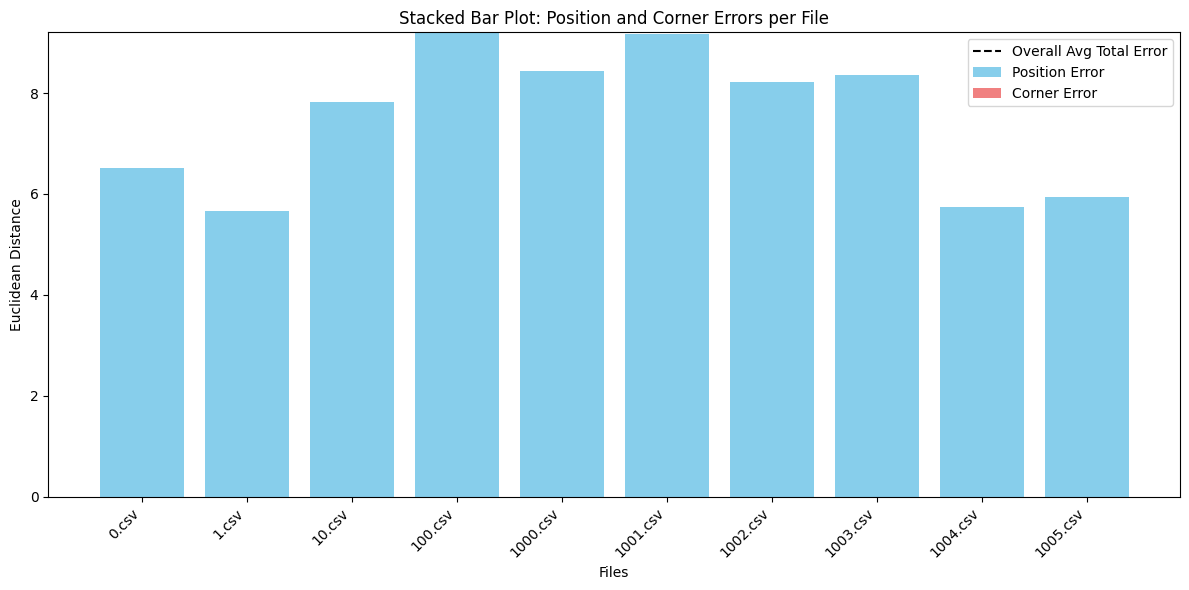

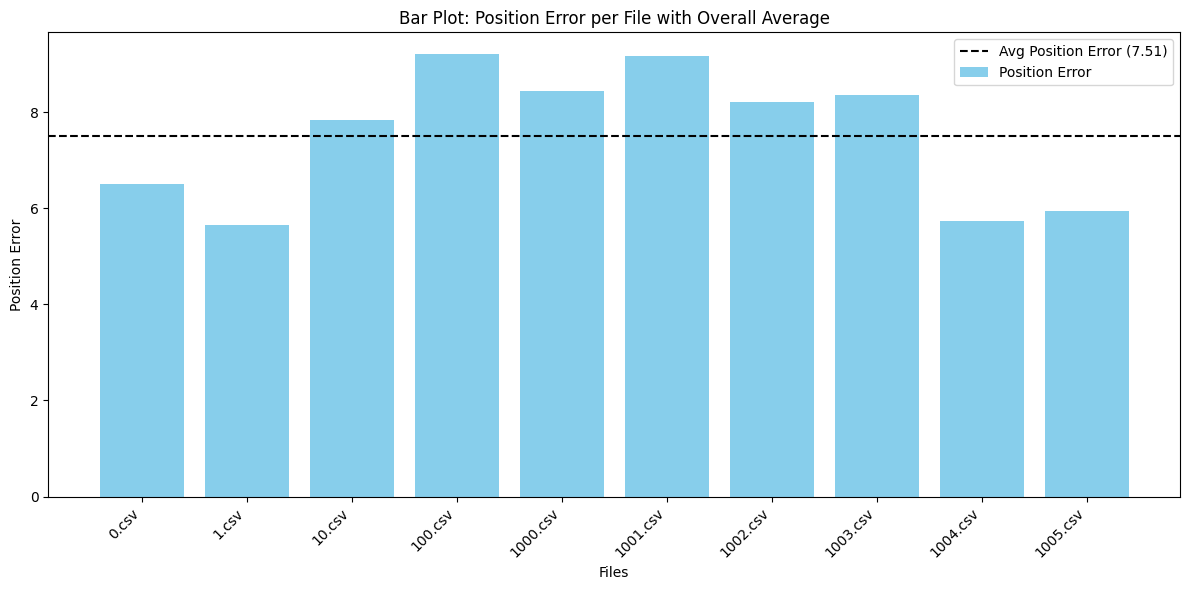

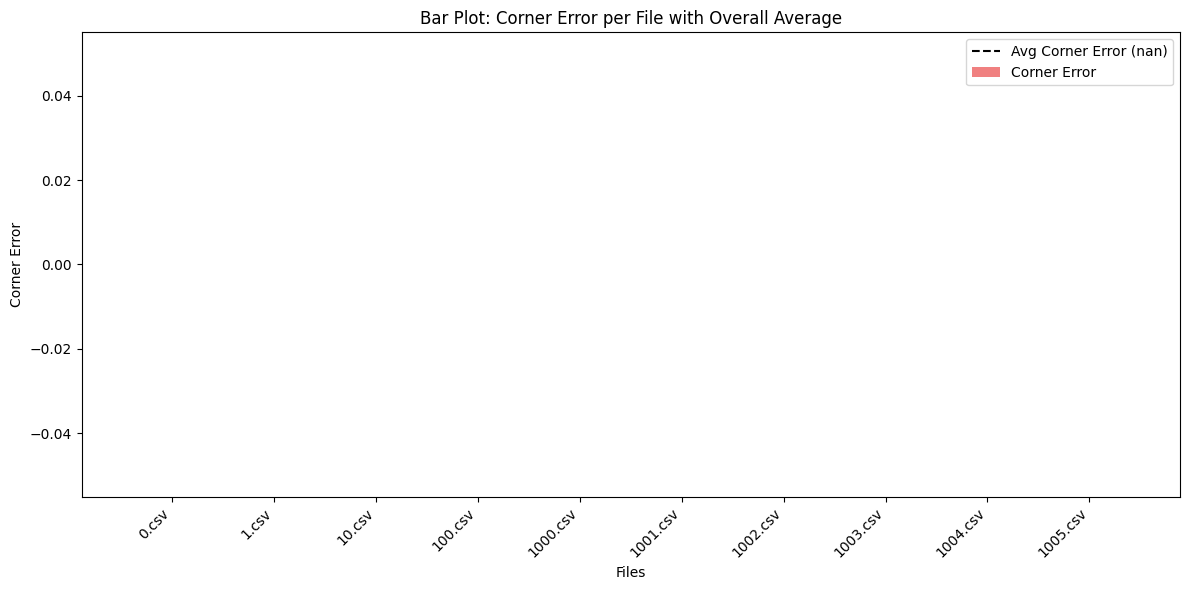

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def generate_3d_distance_plots(results):
    """
    Generate stacked bar plots for position and corner errors.
    Also generate individual plots for position and corner with average lines.
    """
    # Prepare data
    file_names = [result.get("file", "Unknown") for result in results]
    position_distances = [
        np.mean([obj.get("min_position_distance", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    corner_distances = [
        np.mean([obj.get("min_corner_error", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    
    # Overall averages
    overall_avg_position = np.mean([dist for dist in position_distances if dist > 0])
    overall_avg_corner = np.mean([dist for dist in corner_distances if dist > 0])
    
    x = np.arange(len(file_names))
    
    # Stacked Bar Plot: Position and Corner Errors
    plt.figure(figsize=(12, 6))
    plt.bar(x, position_distances, label="Position Error", color="skyblue")
    plt.bar(x, corner_distances, bottom=position_distances, label="Corner Error", color="lightcoral")
    plt.axhline(overall_avg_position + overall_avg_corner, color="black", linestyle="--", label="Overall Avg Total Error")
    plt.xticks(x, file_names, rotation=45, ha="right")
    plt.xlabel("Files")
    plt.ylabel("Euclidean Distance")
    plt.title("Stacked Bar Plot: Position and Corner Errors per File")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Individual Plot: Position Error with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, position_distances, color="skyblue", label="Position Error")
    plt.axhline(overall_avg_position, color="black", linestyle="--", label=f"Avg Position Error ({overall_avg_position:.2f})")
    plt.xticks(x, file_names, rotation=45, ha="right")
    plt.xlabel("Files")
    plt.ylabel("Position Error")
    plt.title("Bar Plot: Position Error per File with Overall Average")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Individual Plot: Corner Error with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, corner_distances, color="lightcoral", label="Corner Error")
    plt.axhline(overall_avg_corner, color="black", linestyle="--", label=f"Avg Corner Error ({overall_avg_corner:.2f})")
    plt.xticks(x, file_names, rotation=45, ha="right")
    plt.xlabel("Files")
    plt.ylabel("Corner Error")
    plt.title("Bar Plot: Corner Error per File with Overall Average")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Generate the plots
generate_3d_distance_plots(results)


In [14]:
import os
import pandas as pd
import numpy as np

# Path to the directories
base_path_2d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\2d_data"
base_path_3d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\3d_data"

# Functions to calculate errors
def calculate_mse(predicted, actual):
    return np.mean((predicted - actual) ** 2)

def calculate_rmse(predicted, actual):
    return np.sqrt(calculate_mse(predicted, actual))

def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))

# List of files to process
file_list = [file_name for file_name in os.listdir(base_path_2d) if file_name.endswith(".csv")]
total_files = len(file_list)

# Loop through the 2D files
errors = {}
for idx, file_name in enumerate(file_list):
    print(f"Processing file {idx + 1}/{total_files} ({((idx + 1) / total_files) * 100:.2f}%) - {file_name}")

    file_2d_path = os.path.join(base_path_2d, file_name)
    file_3d_path = os.path.join(base_path_3d, file_name)

    # Check if the corresponding 3D file exists
    if not os.path.exists(file_3d_path):
        print(f"3D data file for {file_name} not found. Skipping.")
        continue

    # Predict 3D points using the provided function
    predicted_3d = load_model_and_predict_3d(file_2d_path)
    if predicted_3d is None:
        print(f"Prediction failed for {file_name}. Skipping.")
        continue

    # Read the actual 3D points
    try:
        actual_3d_df = pd.read_csv(file_3d_path, header=None)
        actual_3d = actual_3d_df.iloc[:, 1:].values  # Drop the ID column
    except Exception as e:
        print(f"Error loading or processing 3D data for {file_name}: {e}")
        continue

    # Initialize error tracking for this file
    position_rmse, rotation_rmse, corner_rmse = [], [], []
    position_mae, rotation_mae, corner_mae = [], [], []
    total_object_rmse, total_object_mae = [], []

    # Loop through each row (object) in the file
    for i in range(predicted_3d.shape[0]):
        pred = predicted_3d[i]
        actual = actual_3d[i]

        # Ensure conversion to NumPy for each row
        if isinstance(pred, torch.Tensor):
            pred = pred.numpy()
        if isinstance(actual, torch.Tensor):
            actual = actual.numpy()

        # Extract components
        pred_position = pred[:3]
        actual_position = actual[:3]

        pred_rotation = pred[3:6]
        actual_rotation = actual[3:6]

        pred_corners = pred[6:].reshape(8, 3)
        actual_corners = actual[6:].reshape(8, 3)

        # Calculate RMSE and MAE for position, rotation, and corners
        pos_rmse = calculate_rmse(pred_position, actual_position)
        rot_rmse = calculate_rmse(pred_rotation, actual_rotation)
        corner_rmse_values = [calculate_rmse(pred_corners[j], actual_corners[j]) for j in range(8)]
        
        pos_mae = calculate_mae(pred_position, actual_position)
        rot_mae = calculate_mae(pred_rotation, actual_rotation)
        corner_mae_values = [calculate_mae(pred_corners[j], actual_corners[j]) for j in range(8)]

        # Total RMSE and MAE for this object
        object_rmse = pos_rmse + rot_rmse + sum(corner_rmse_values)
        object_mae = pos_mae + rot_mae + sum(corner_mae_values)

        # Append errors
        position_rmse.append(pos_rmse)
        rotation_rmse.append(rot_rmse)
        corner_rmse.append(sum(corner_rmse_values) / 8)  # Avg corner RMSE
        
        position_mae.append(pos_mae)
        rotation_mae.append(rot_mae)
        corner_mae.append(sum(corner_mae_values) / 8)  # Avg corner MAE
        
        total_object_rmse.append(object_rmse)
        total_object_mae.append(object_mae)

    # Aggregate RMSE and MAE for the file
    file_rmse = {
        "position": np.mean(position_rmse),
        "rotation": np.mean(rotation_rmse),
        "corners": np.mean(corner_rmse),
        "total": np.mean(total_object_rmse),
    }
    file_mae = {
        "position": np.mean(position_mae),
        "rotation": np.mean(rotation_mae),
        "corners": np.mean(corner_mae),
        "total": np.mean(total_object_mae),
    }

    # Save results
    errors[file_name] = {
        "RMSE": file_rmse,
        "MAE": file_mae,
    }

# Display all errors
errors


Processing file 1/3010 (0.03%)
Processing file 2/3010 (0.07%)
Processing file 3/3010 (0.10%)
Processing file 4/3010 (0.13%)
Processing file 5/3010 (0.17%)
Processing file 6/3010 (0.20%)
Processing file 7/3010 (0.23%)
Processing file 8/3010 (0.27%)
Processing file 9/3010 (0.30%)
Processing file 10/3010 (0.33%)
Processing file 11/3010 (0.37%)
Processing file 12/3010 (0.40%)
Processing file 13/3010 (0.43%)
Processing file 14/3010 (0.47%)
Processing file 15/3010 (0.50%)
Processing file 16/3010 (0.53%)
Processing file 17/3010 (0.56%)
Processing file 18/3010 (0.60%)
Processing file 19/3010 (0.63%)
Processing file 20/3010 (0.66%)
Processing file 21/3010 (0.70%)
Processing file 22/3010 (0.73%)
Processing file 23/3010 (0.76%)
Processing file 24/3010 (0.80%)
Processing file 25/3010 (0.83%)
Processing file 26/3010 (0.86%)
Processing file 27/3010 (0.90%)
Processing file 28/3010 (0.93%)
Processing file 29/3010 (0.96%)
Processing file 30/3010 (1.00%)
Processing file 31/3010 (1.03%)
Processing file 3

{'0.csv': {'RMSE': {'position': 1.5713327881319377,
   'rotation': 70.25418078425825,
   'corners': 1.6161595641949642,
   'total': 84.75479008594989},
  'MAE': {'position': 1.3290428436485655,
   'rotation': 40.564142083324136,
   'corners': 1.3274256799586222,
   'total': 52.51259036664168}},
 '1.csv': {'RMSE': {'position': 2.070666355147053,
   'rotation': 25.684165088236377,
   'corners': 2.1173556213296996,
   'total': 44.69367641402103},
  'MAE': {'position': 1.6895769721033098,
   'rotation': 14.83267749405507,
   'corners': 1.6574062258014535,
   'total': 29.781504272570004}},
 '10.csv': {'RMSE': {'position': 2.078921262480032,
   'rotation': 29.616941073878536,
   'corners': 2.056840560141037,
   'total': 48.15058681748686},
  'MAE': {'position': 1.6815525564435323,
   'rotation': 17.10390562777184,
   'corners': 1.6554088124060182,
   'total': 32.02872868346352}},
 '100.csv': {'RMSE': {'position': 1.6423932176749965,
   'rotation': 50.90165492514679,
   'corners': 1.619654900

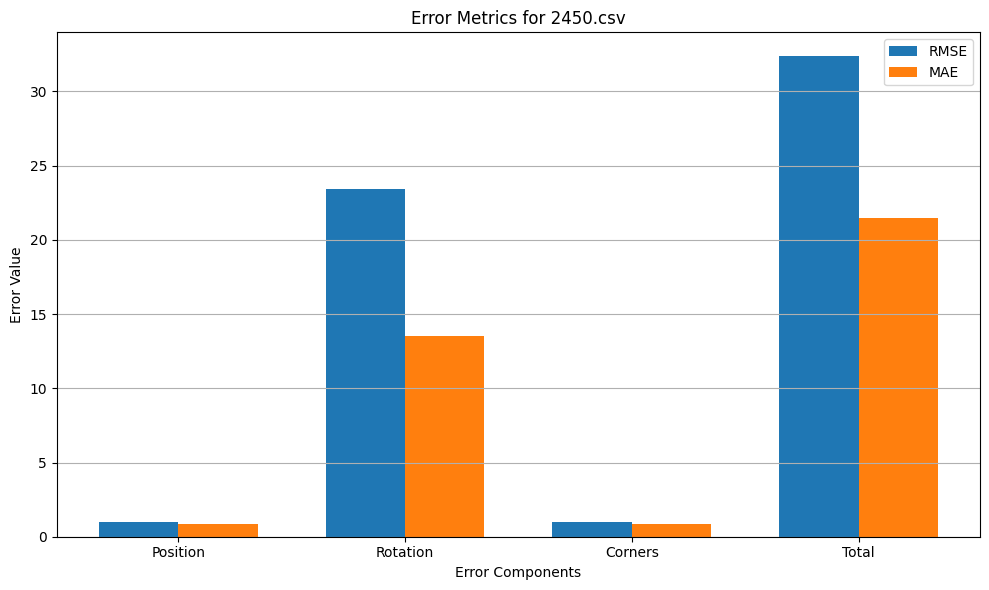

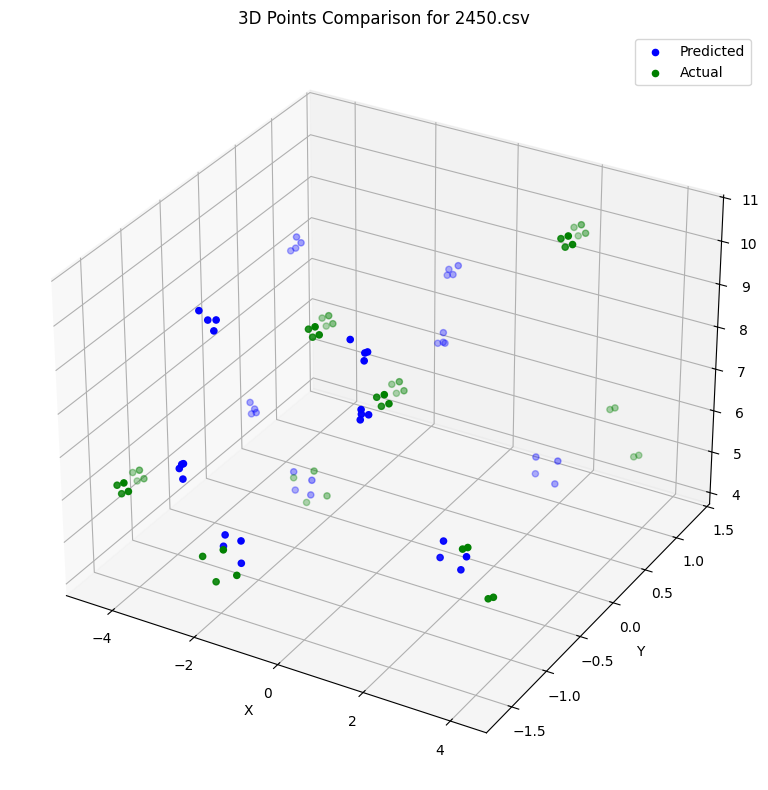

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_errors_one_file(file_name, predicted_3d, actual_3d):
    if file_name not in errors:
        print(f"No errors found for {file_name}.")
        return

    # Extract RMSE and MAE for the file
    file_rmse = errors[file_name]["RMSE"]
    file_mae = errors[file_name]["MAE"]

    # Plot RMSE and MAE as bar charts
    labels = ["Position", "Rotation", "Corners", "Total"]
    rmse_values = [file_rmse["position"], file_rmse["rotation"], file_rmse["corners"], file_rmse["total"]]
    mae_values = [file_mae["position"], file_mae["rotation"], file_mae["corners"], file_mae["total"]]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, rmse_values, width, label="RMSE")
    plt.bar(x + width / 2, mae_values, width, label="MAE")

    plt.xlabel("Error Components")
    plt.ylabel("Error Value")
    plt.title(f"Error Metrics for {file_name}")
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 3D scatter plot for predicted vs. actual 3D points
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    for i in range(predicted_3d.shape[0]):
        pred = predicted_3d[i]
        actual = actual_3d[i]

        pred_corners = pred[6:].reshape(8, 3)
        actual_corners = actual[6:].reshape(8, 3)

        # Plot predicted corners in blue
        ax.scatter(pred_corners[:, 0], pred_corners[:, 1], pred_corners[:, 2], color="blue", label="Predicted" if i == 0 else "")
        # Plot actual corners in green
        ax.scatter(actual_corners[:, 0], actual_corners[:, 1], actual_corners[:, 2], color="green", label="Actual" if i == 0 else "")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"3D Points Comparison for {file_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()

file_name = "2450.csv"
predicted_3d = load_model_and_predict_3d(os.path.join(base_path_2d, file_name))
actual_3d_df = pd.read_csv(os.path.join(base_path_3d, file_name), header=None)
actual_3d = actual_3d_df.iloc[:, 1:].values

visualize_errors_one_file(file_name, predicted_3d, actual_3d)

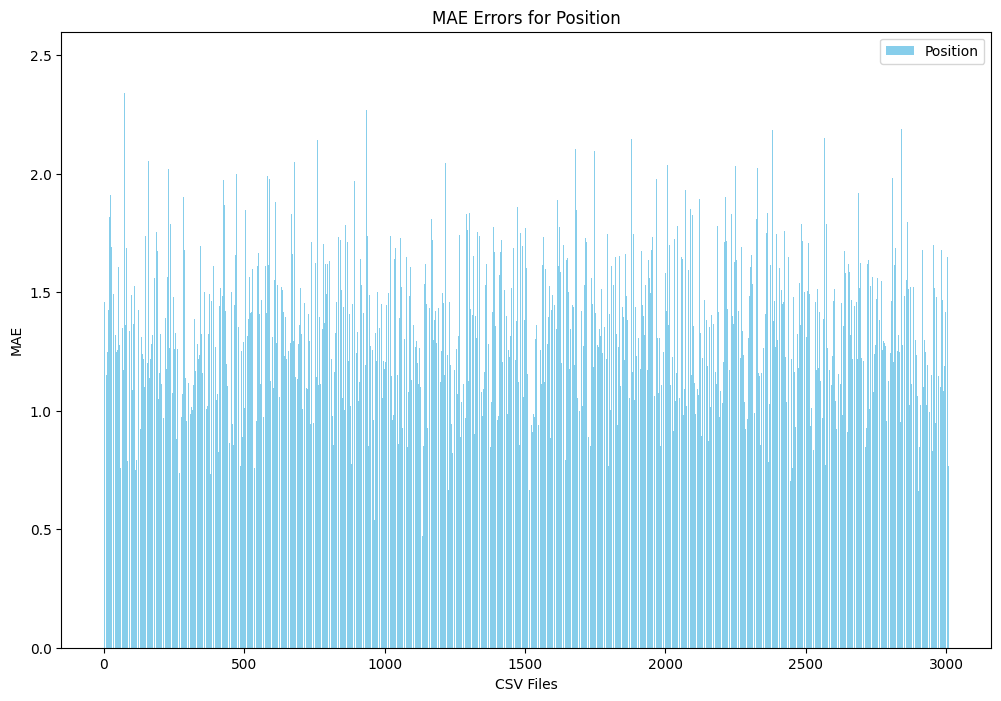

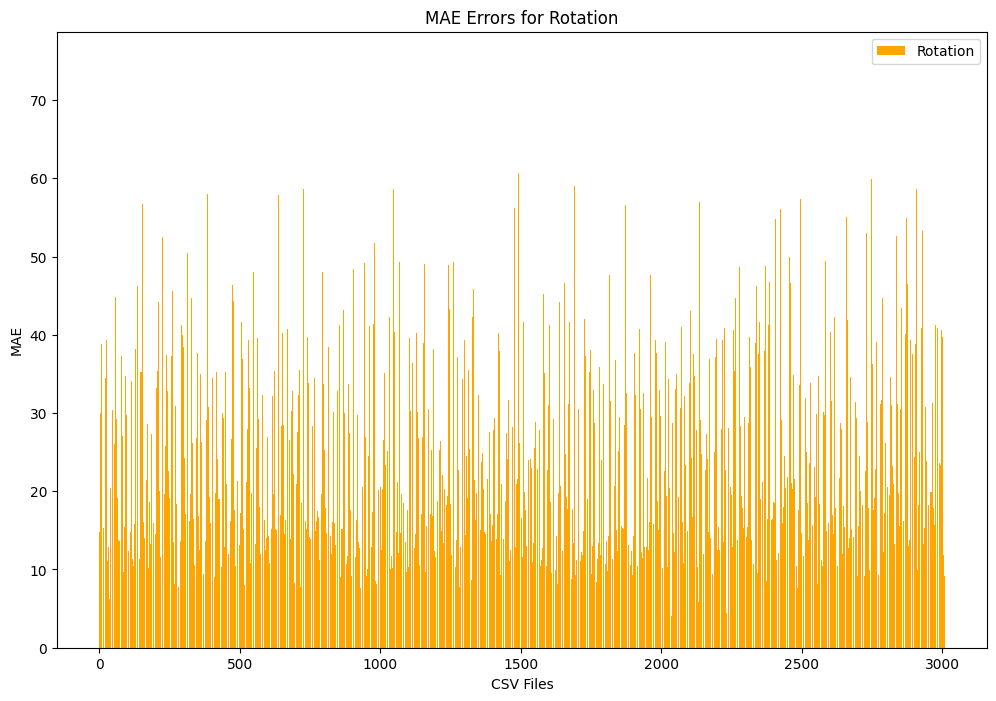

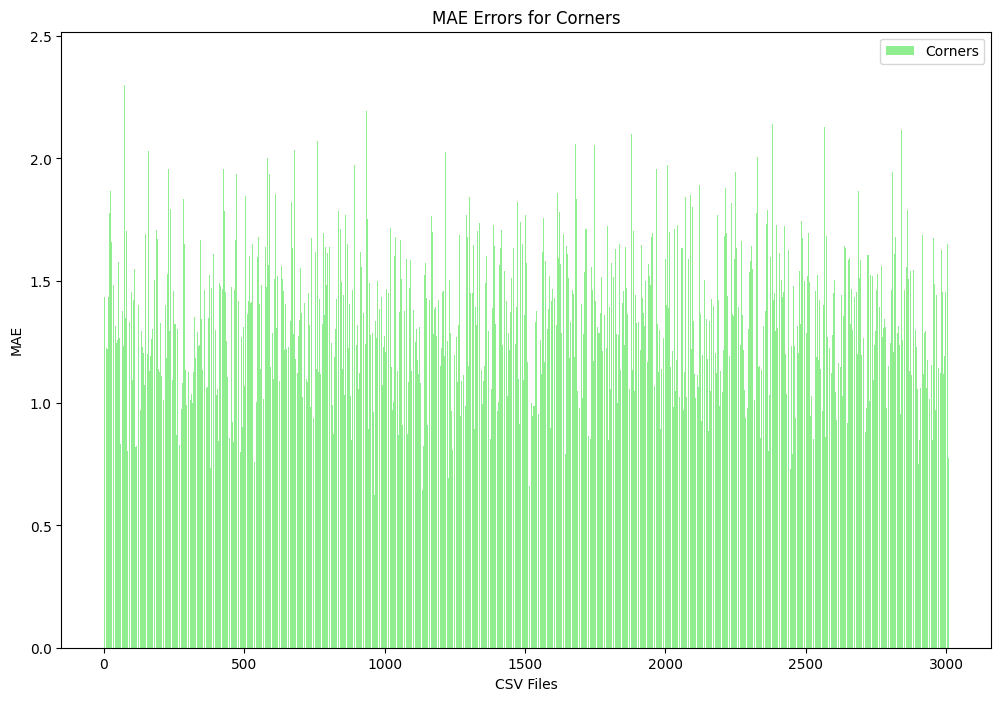

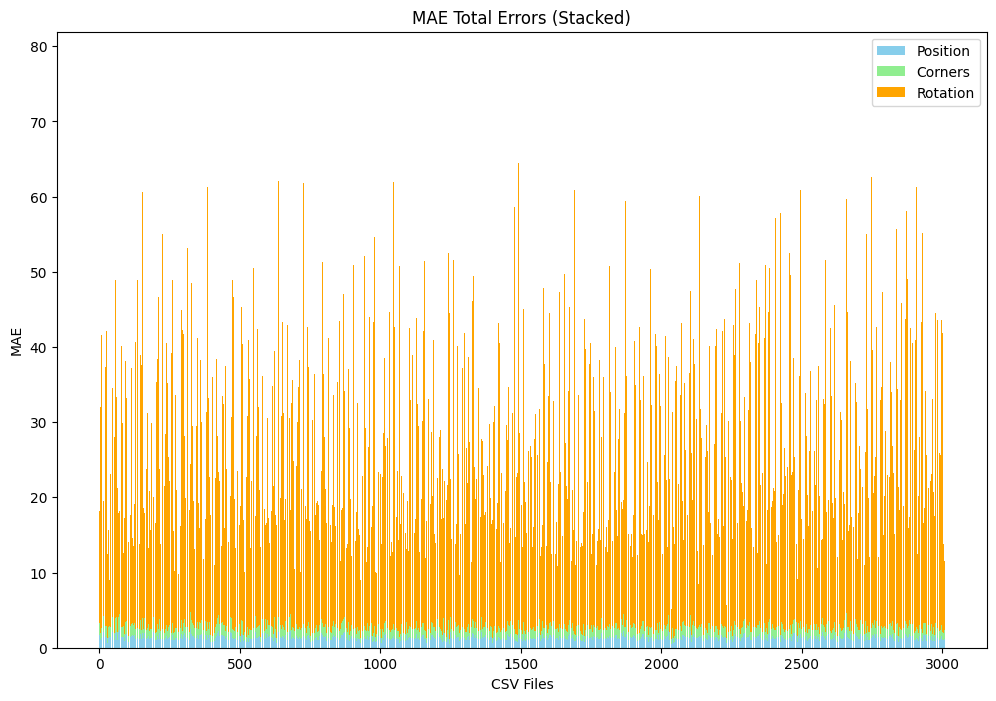

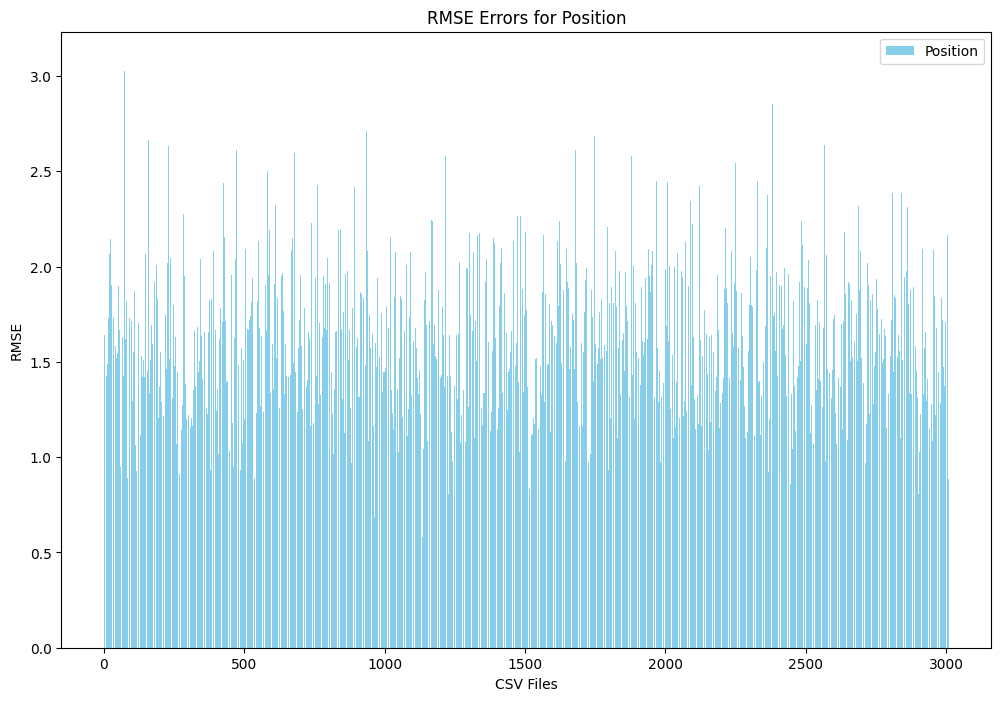

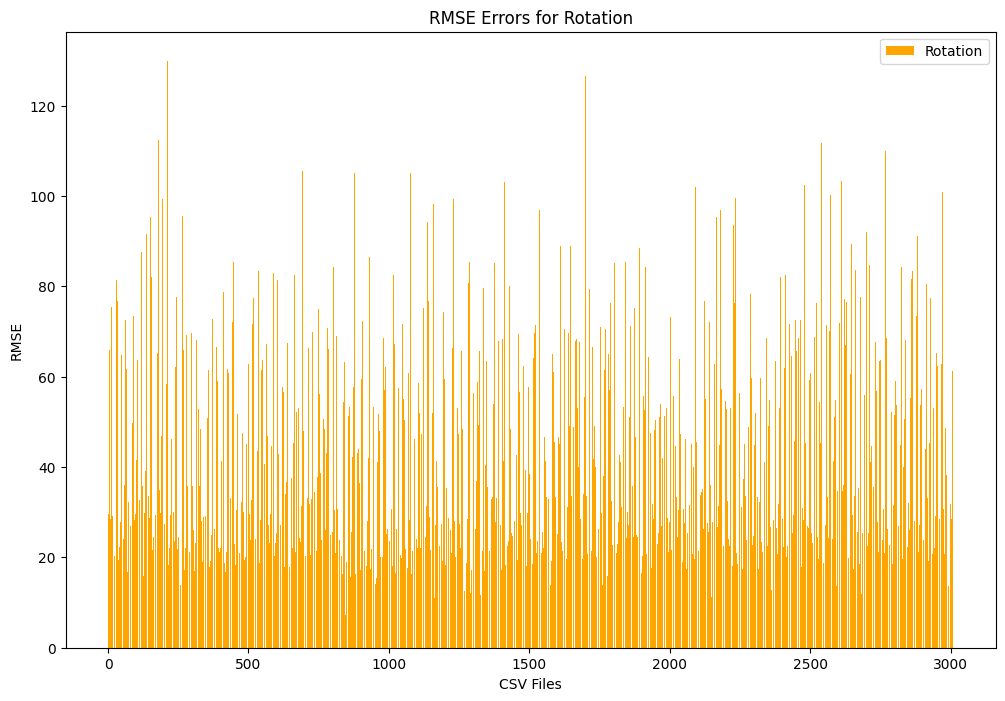

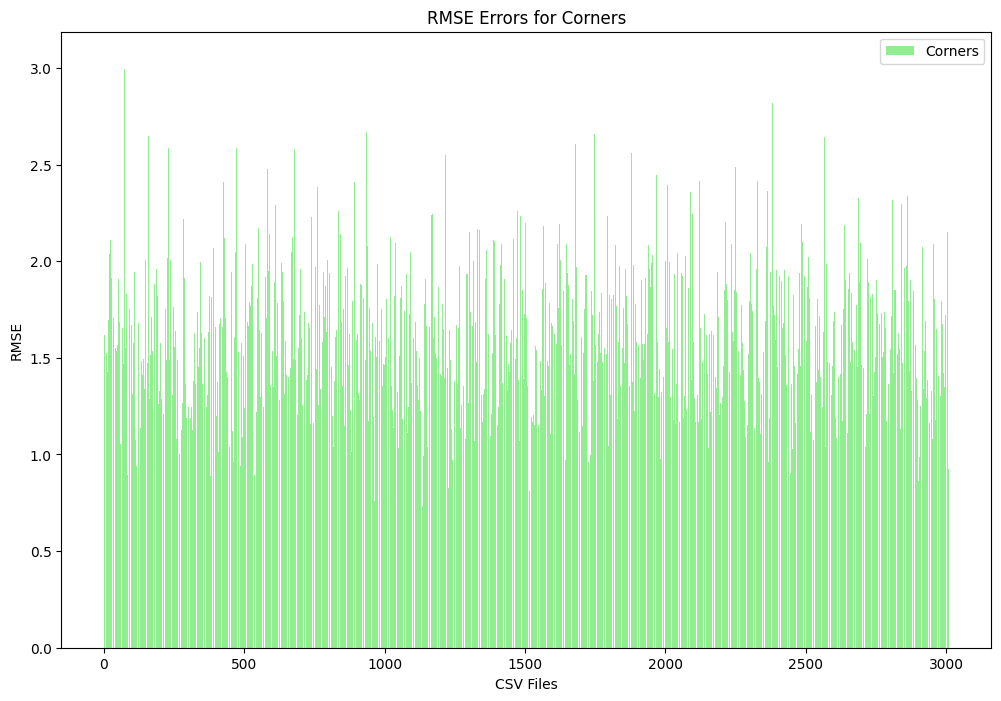

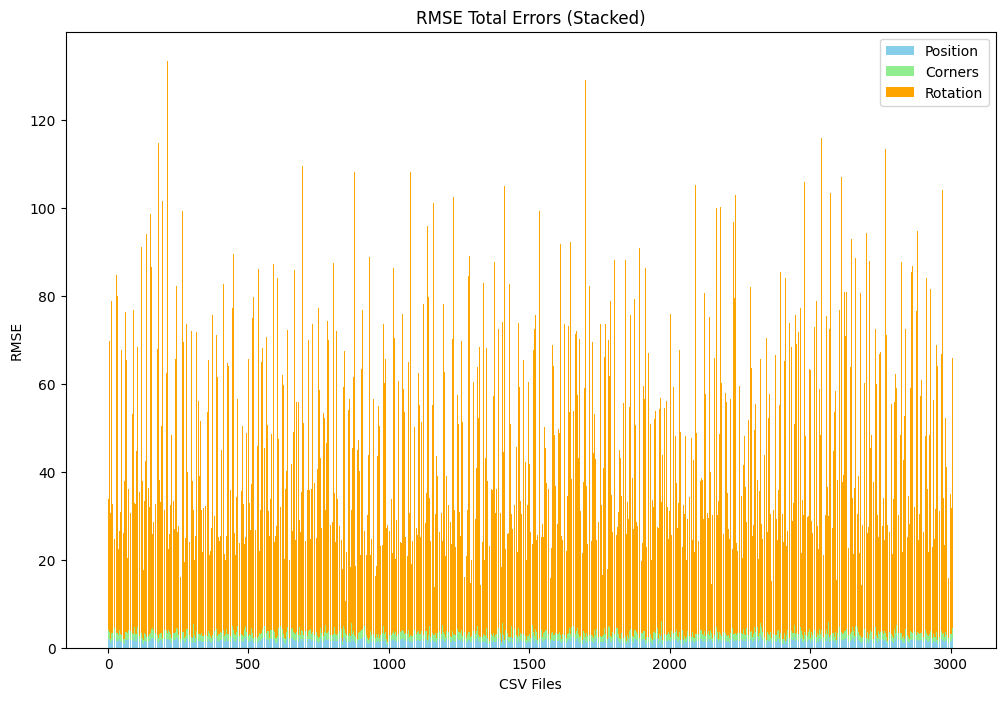

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_individual(df, x, metric, component, color):
    """
    Plot an individual bar chart for a specific component.

    Parameters:
        df (DataFrame): DataFrame containing error metrics.
        x (array): X-axis positions for bars.
        metric (str): Metric type (e.g., "MAE", "RMSE").
        component (str): Component to plot (e.g., "Position", "Rotation", "Corners").
        color (str): Bar color.
    """
    plt.figure(figsize=(12, 8))
    plt.bar(x, df[f"{metric}_{component}"], color=color, label=component)
    plt.xlabel("CSV Files")
    plt.ylabel(metric)
    plt.title(f"{metric} Errors for {component}")
    plt.legend()
    plt.show()

def plot_stacked(df, x, metric):
    """
    Plot a stacked bar chart for total errors.

    Parameters:
        df (DataFrame): DataFrame containing error metrics.
        x (array): X-axis positions for bars.
        metric (str): Metric type (e.g., "MAE", "RMSE").
    """
    plt.figure(figsize=(12, 8))
    plt.bar(x, df[f"{metric}_Position"], color="skyblue", label="Position")
    plt.bar(x, df[f"{metric}_Corners"], bottom=df[f"{metric}_Position"], color="lightgreen", label="Corners")
    plt.bar(
        x,
        df[f"{metric}_Rotation"],
        bottom=df[f"{metric}_Position"] + df[f"{metric}_Corners"],
        color="orange",
        label="Rotation",
    )
    plt.xlabel("CSV Files")
    plt.ylabel(metric)
    plt.title(f"{metric} Total Errors (Stacked)")
    plt.legend()
    plt.show()

def visualize_errors_all_files(errors):
    """
    Visualize errors (individual and stacked) for RMSE and MAE across all files.

    Parameters:
        errors (dict): Dictionary containing error metrics for each file.
    """
    # Extract errors into DataFrame
    data = []
    for file_name, metrics in errors.items():
        rmse = metrics["RMSE"]
        mae = metrics["MAE"]
        data.append([
            file_name,
            rmse["position"], rmse["rotation"], rmse["corners"],
            mae["position"], mae["rotation"], mae["corners"]
        ])

    columns = ["File", "RMSE_Position", "RMSE_Rotation", "RMSE_Corners",
               "MAE_Position", "MAE_Rotation", "MAE_Corners"]
    df = pd.DataFrame(data, columns=columns)

    x = np.arange(len(df))

    # Plot RMSE and MAE components (individual and stacked)
    for metric in ["MAE", "RMSE"]:
        for component, color in zip(["Position", "Rotation", "Corners"], ["skyblue", "orange", "lightgreen"]):
            plot_individual(df, x, metric, component, color)
        plot_stacked(df, x, metric)

# Example: Visualize errors
visualize_errors_all_files(errors)


Selected Files for Visualization:
['1518.csv', '369.csv', '68.csv', '2596.csv', '1707.csv', '2229.csv', '1856.csv', '2689.csv', '2510.csv', '1758.csv']


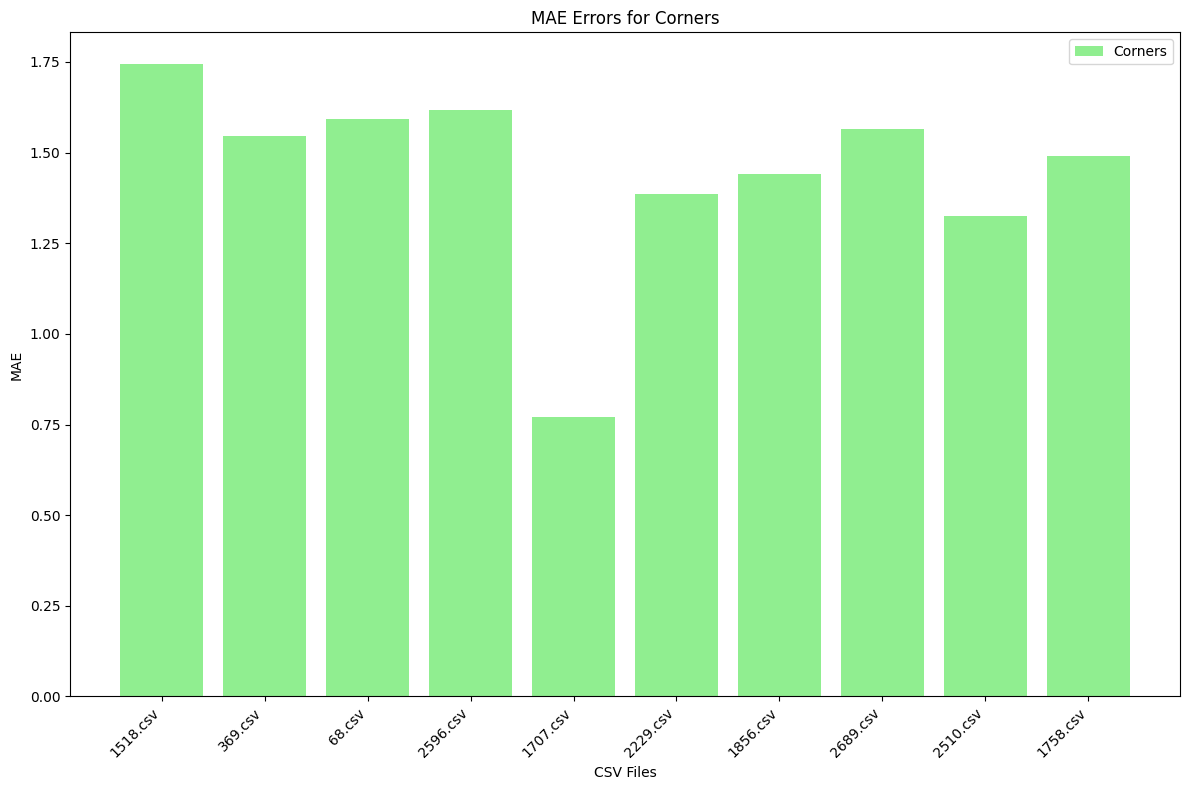

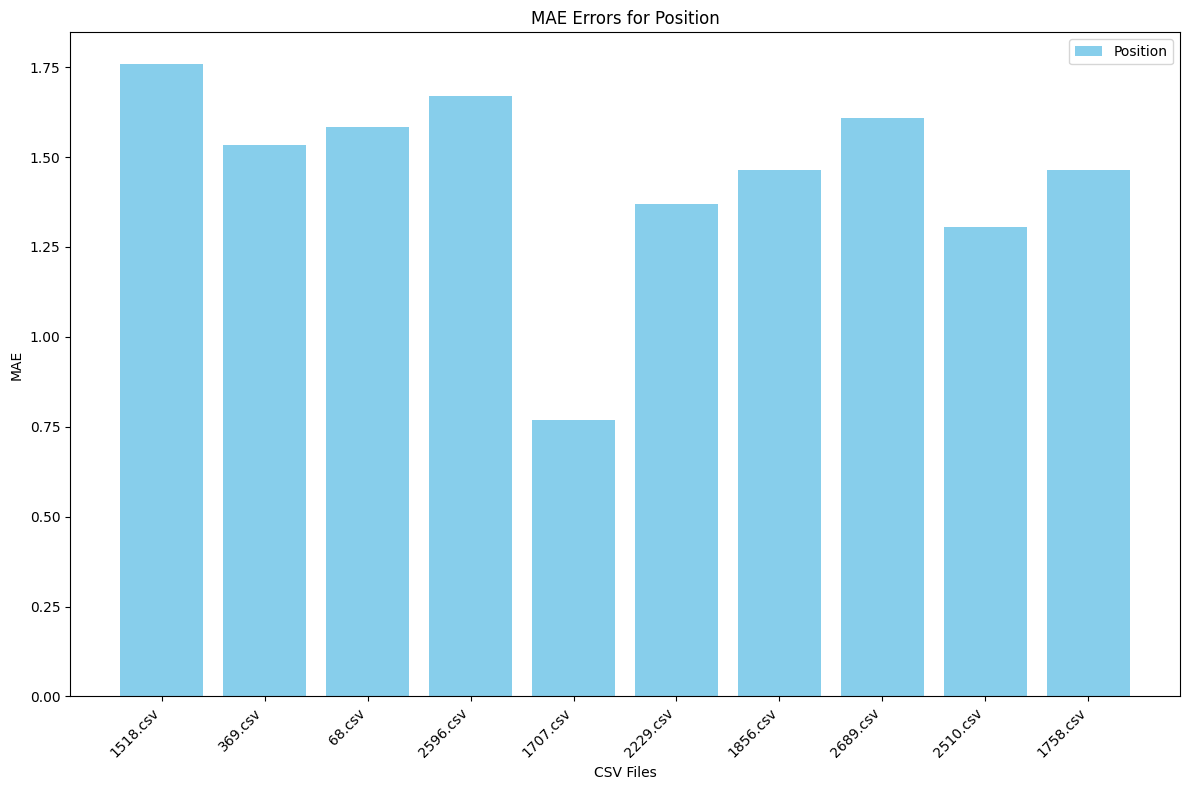

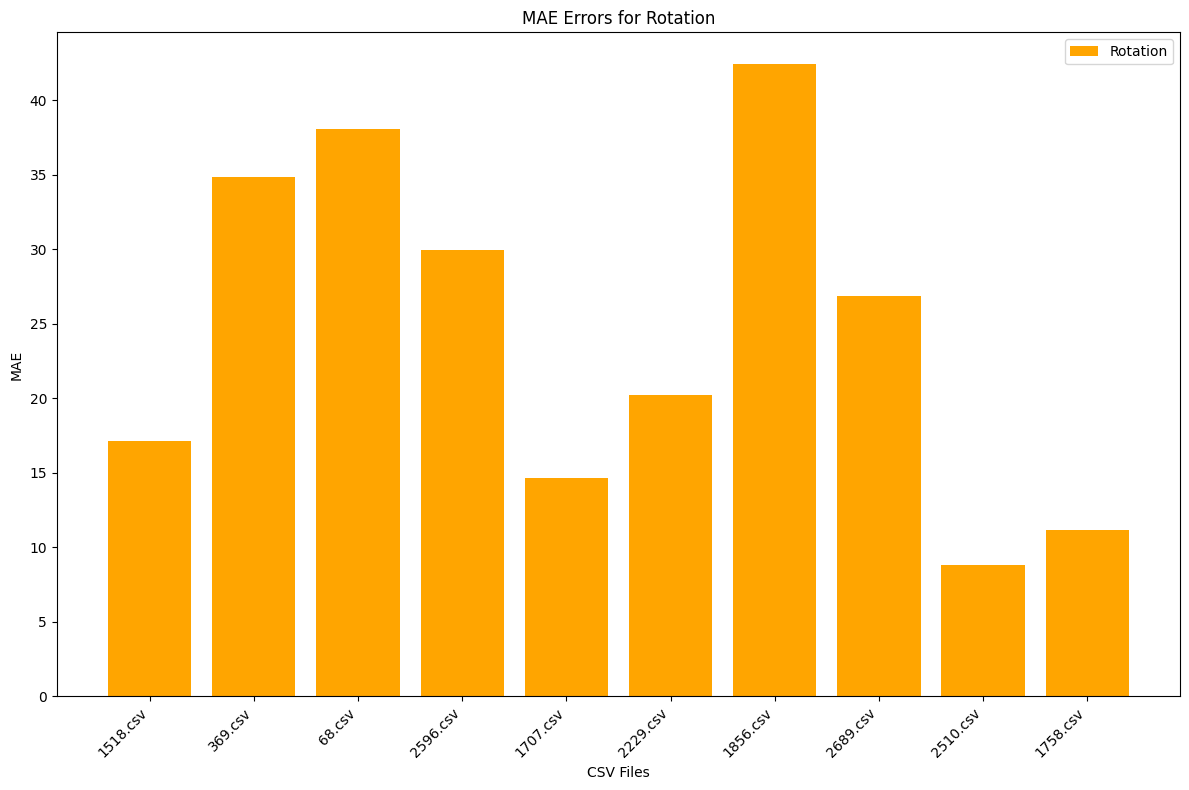

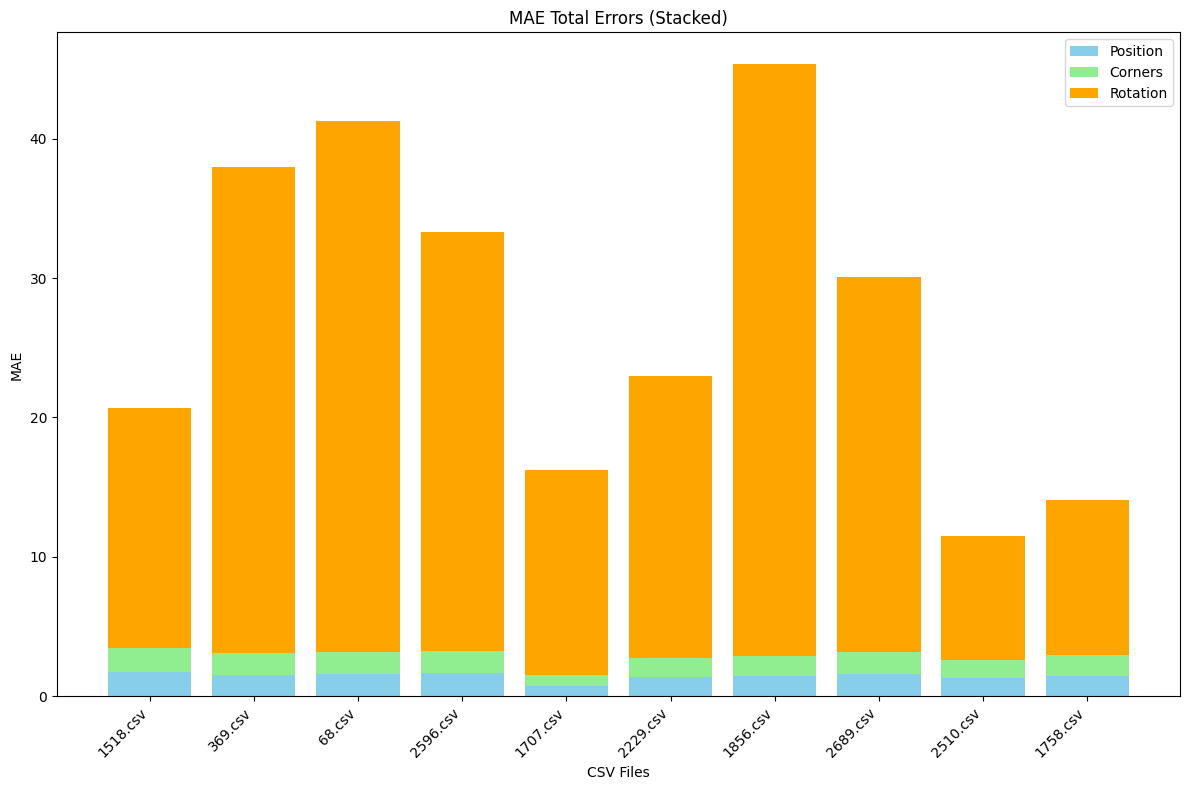

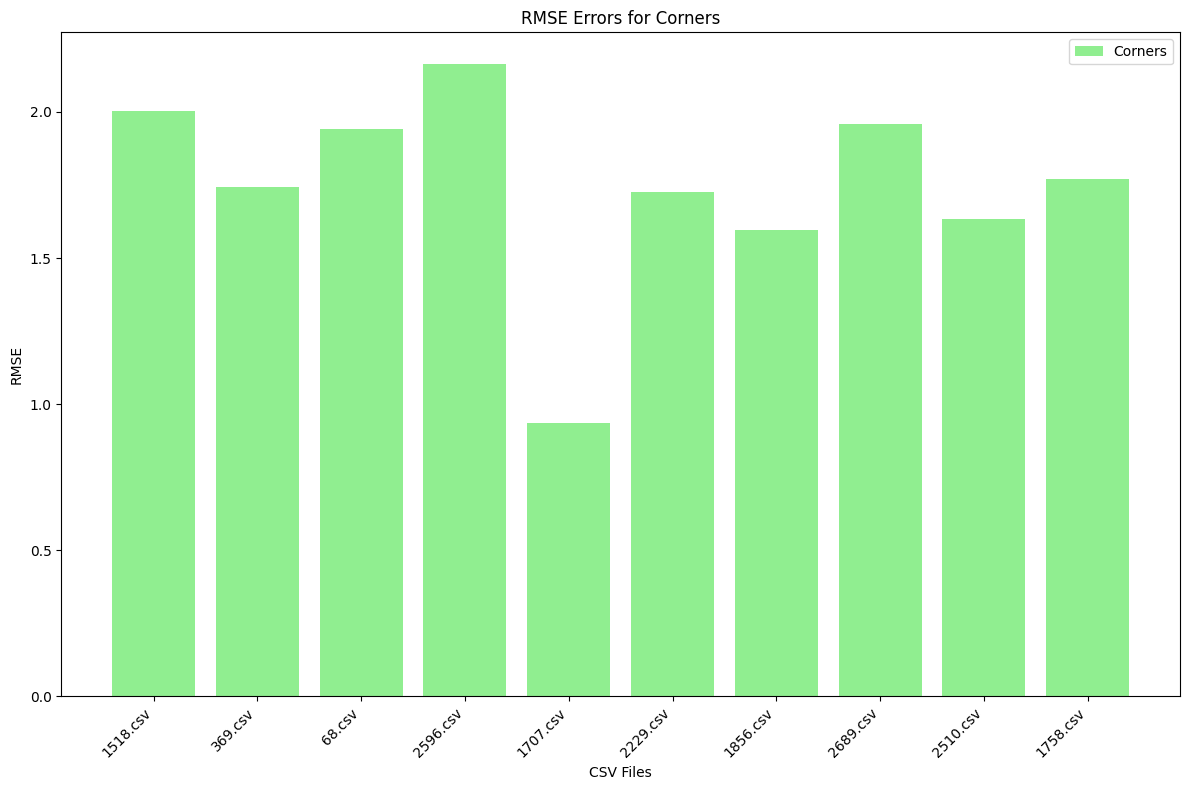

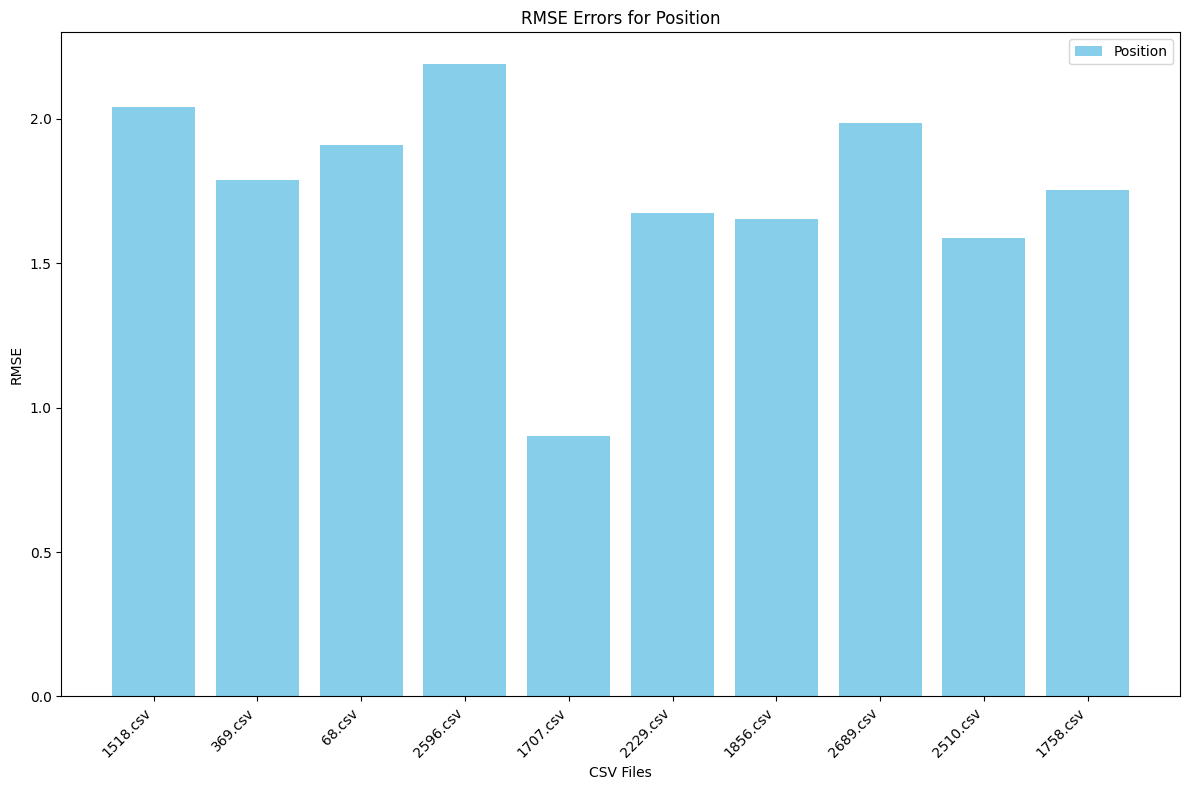

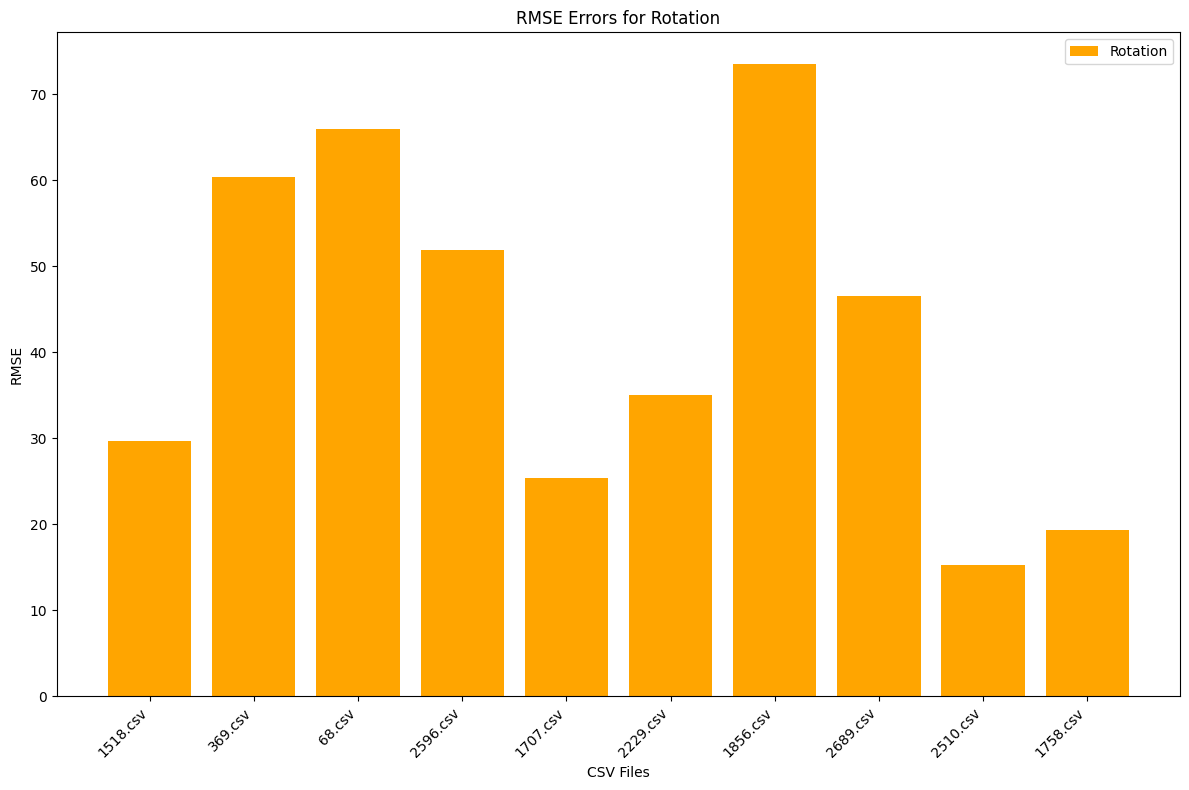

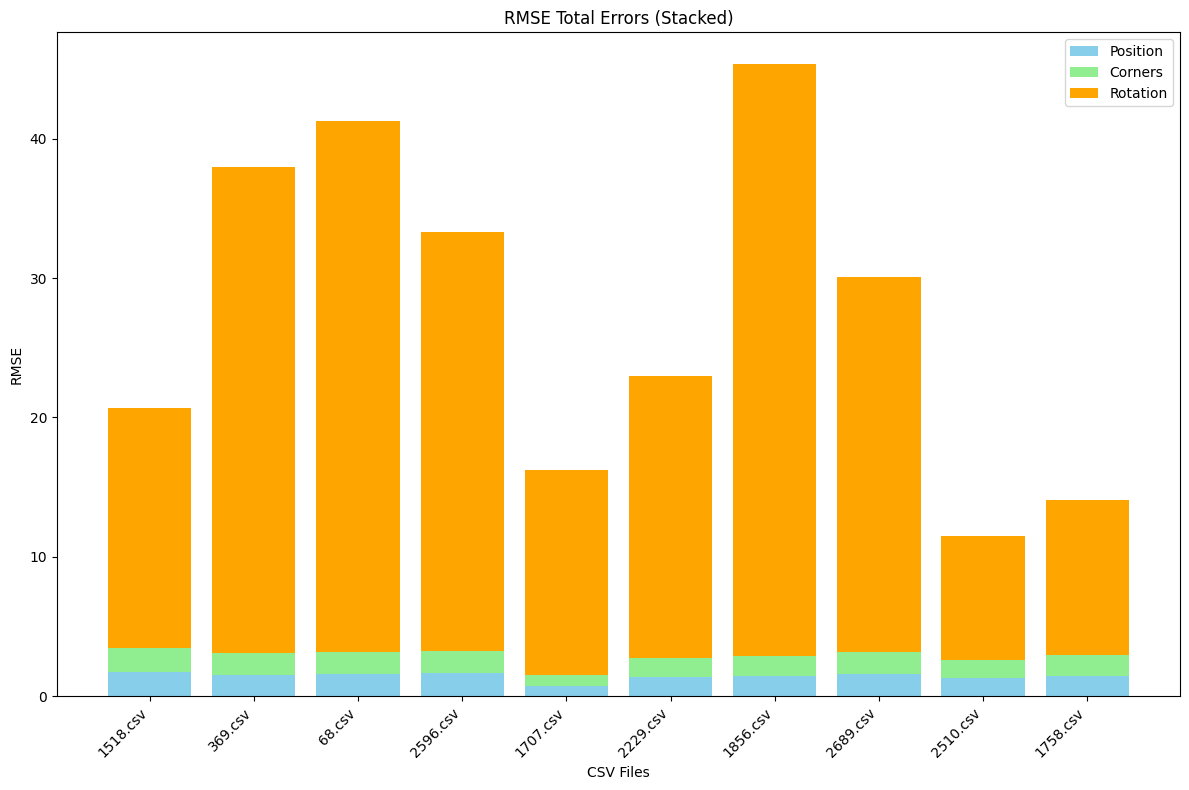

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Randomly select 10 files from the errors dictionary
selected_files = random.sample(list(errors.keys()), 10)

# Extract the selected errors into a new dictionary
selected_errors = {file: errors[file] for file in selected_files}

print("Selected Files for Visualization:")
print(selected_files)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_selected_errors_stacked(selected_errors):
    # Extract errors into DataFrame
    data = []
    for file_name, metrics in selected_errors.items():
        rmse = metrics["RMSE"]
        mae = metrics["MAE"]
        data.append([
            file_name,
            rmse["position"], rmse["rotation"], rmse["corners"],
            mae["position"], mae["rotation"], mae["corners"]
        ])

    columns = ["File", "RMSE_Position", "RMSE_Rotation", "RMSE_Corners","MAE_Position", "MAE_Rotation", "MAE_Corners"]
    df = pd.DataFrame(data, columns=columns)

    x = np.arange(len(df))
    
    # 4 for MAE
    plt.figure(figsize=(12, 8))
    plt.bar(x, df["MAE_Corners"], color="lightgreen", label="Corners")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("MAE")
    plt.title("MAE Errors for Corners")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["MAE_Position"], color="skyblue", label="Position")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("MAE")
    plt.title("MAE Errors for Position")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["MAE_Rotation"], color="orange", label="Rotation")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("MAE")
    plt.title("MAE Errors for Rotation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["MAE_Position"], color="skyblue", label="Position")
    plt.bar(x, df["MAE_Corners"], bottom=df["MAE_Position"], color="lightgreen", label="Corners")
    plt.bar(x, df["MAE_Rotation"], bottom=df["MAE_Position"] + df["MAE_Corners"], color="orange", label="Rotation")
    
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("MAE")
    plt.title("MAE Total Errors (Stacked)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4 for RMSE
    plt.figure(figsize=(12, 8))
    plt.bar(x, df["RMSE_Corners"], color="lightgreen", label="Corners")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("RMSE")
    plt.title("RMSE Errors for Corners")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["RMSE_Position"], color="skyblue", label="Position")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("RMSE")
    plt.title("RMSE Errors for Position")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["RMSE_Rotation"], color="orange", label="Rotation")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("RMSE")
    plt.title("RMSE Errors for Rotation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.bar(x, df["RMSE_Position"], color="skyblue", label="Position")
    plt.bar(x, df["MAE_Corners"], bottom=df["MAE_Position"], color="lightgreen", label="Corners")
    plt.bar(x, df["MAE_Rotation"], bottom=df["MAE_Position"] + df["MAE_Corners"], color="orange", label="Rotation")
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel("RMSE")
    plt.title("RMSE Total Errors (Stacked)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize the errors for the selected files
visualize_selected_errors_stacked(selected_errors)


Selected Files for Visualization:
['512.csv', '285.csv', '1236.csv', '2242.csv', '1960.csv', '1225.csv', '2310.csv', '1405.csv', '2405.csv', '1739.csv']


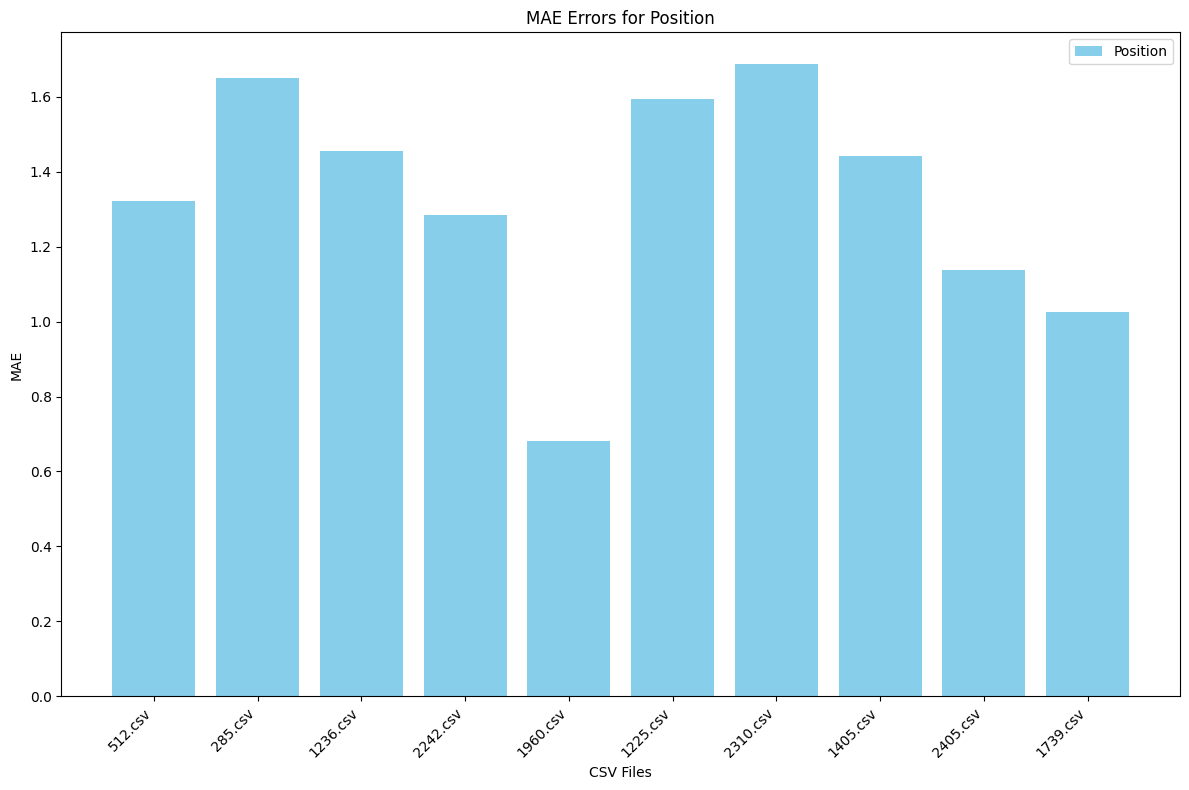

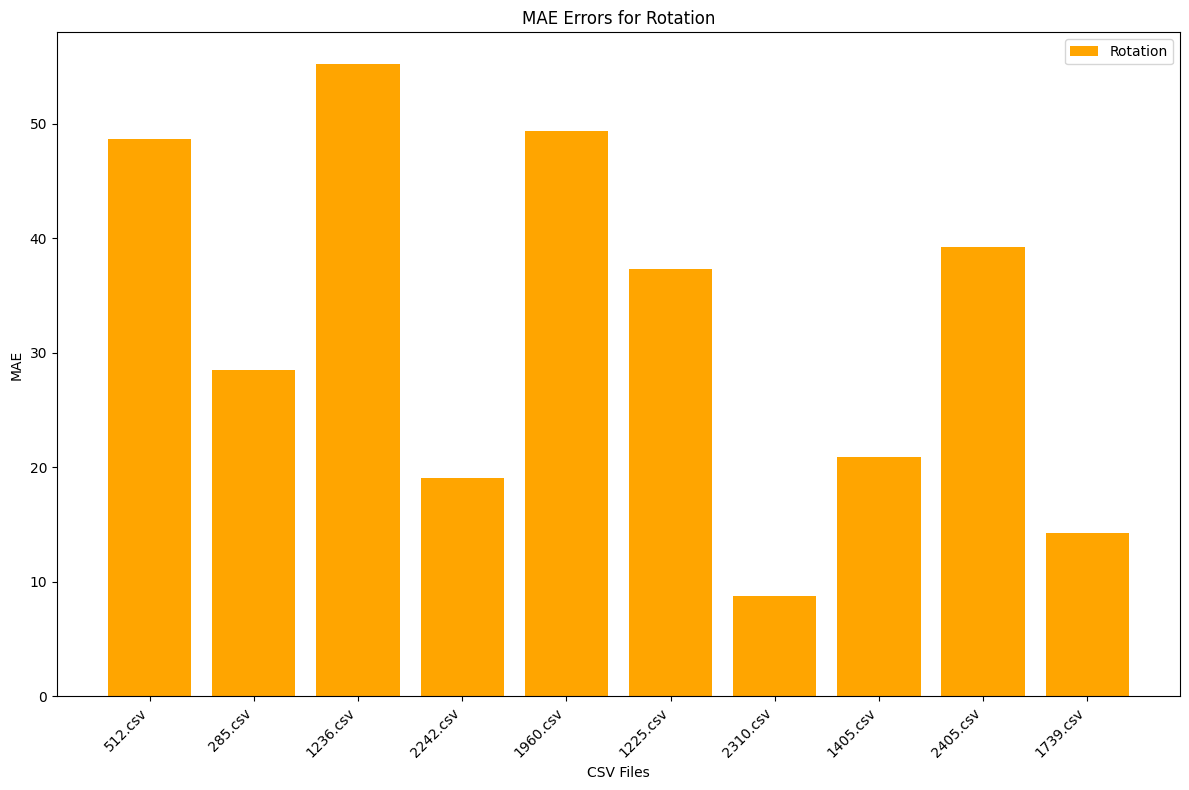

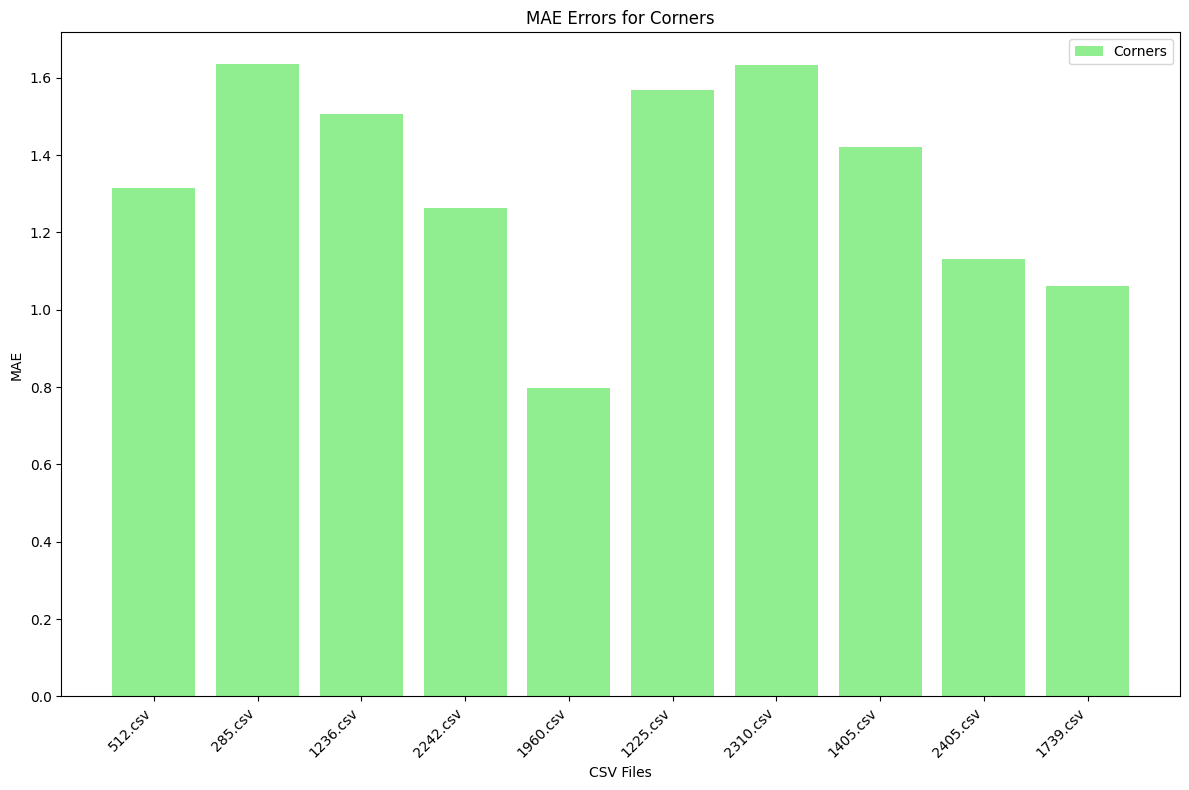

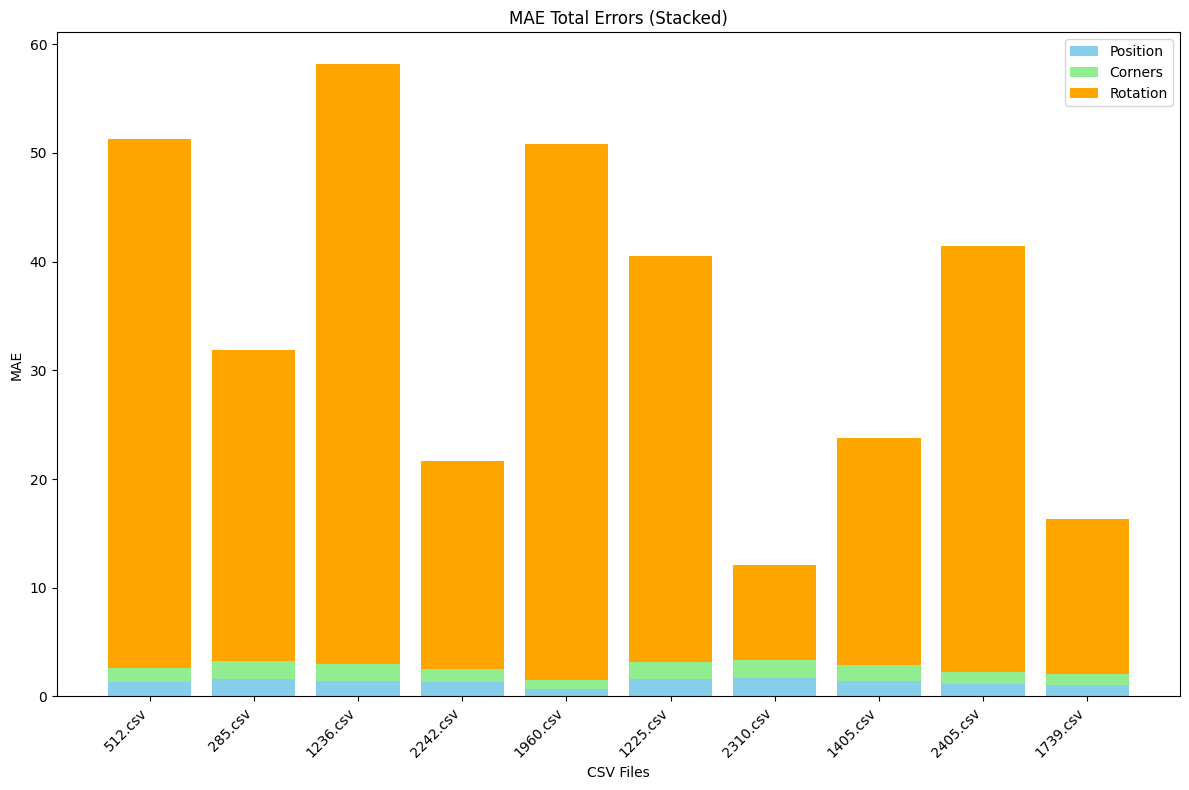

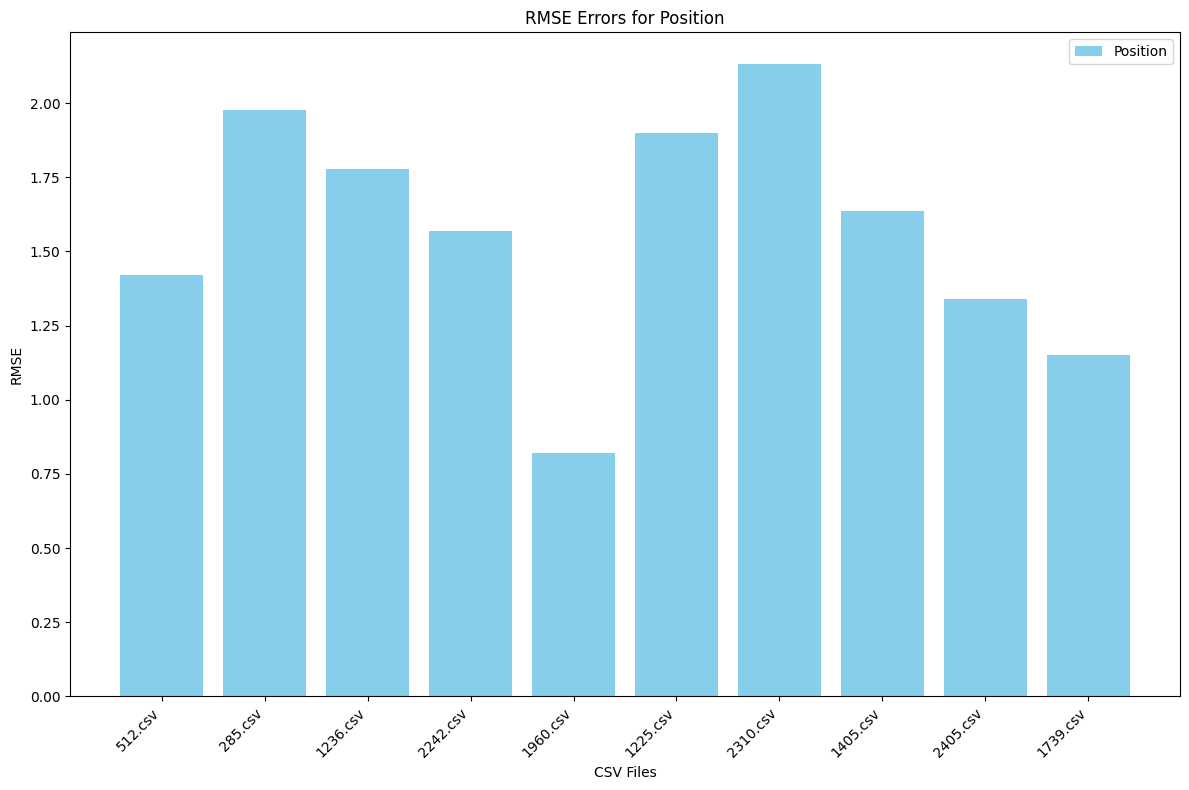

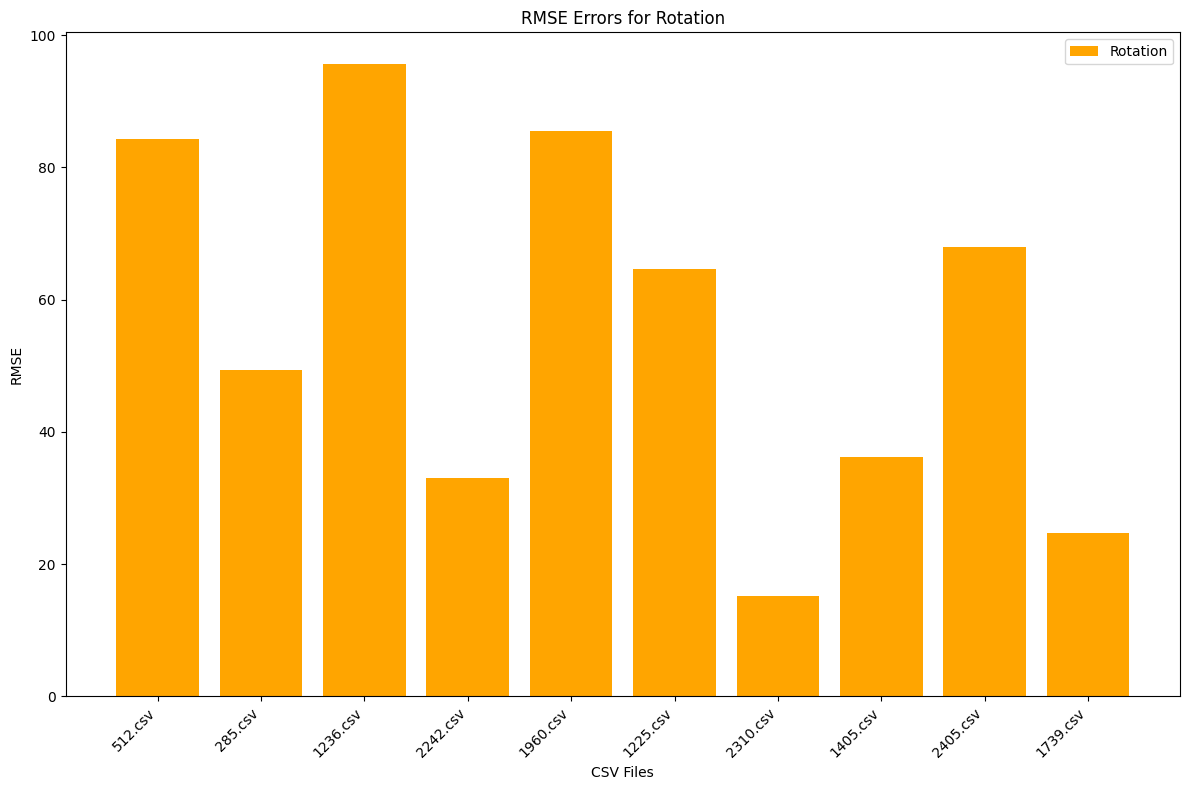

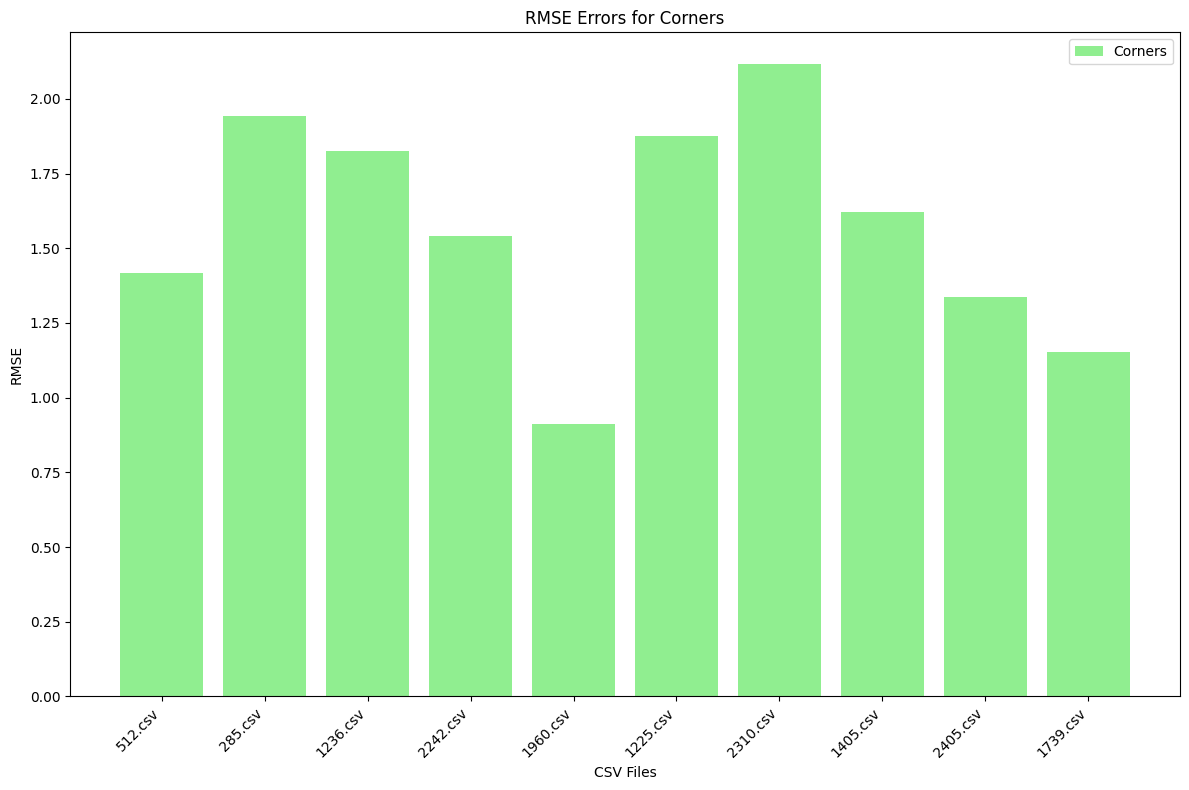

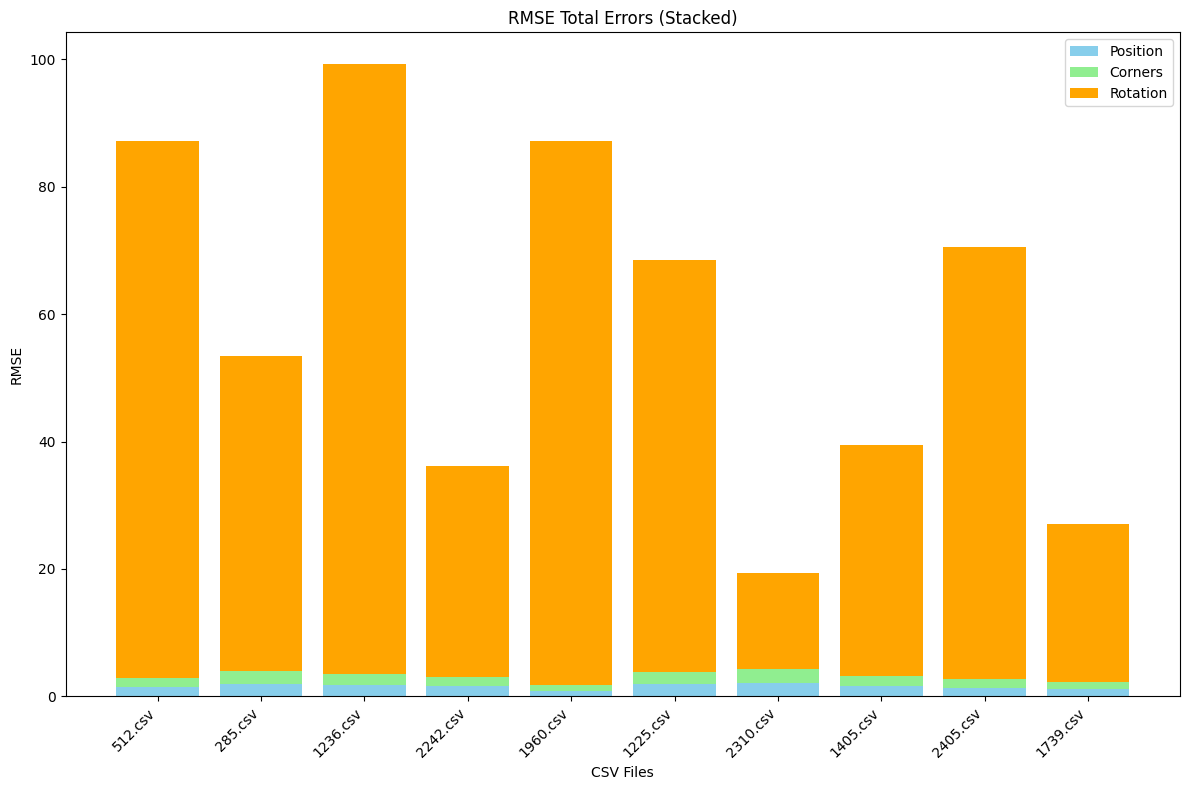

In [23]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_individual_selected(df, x, metric, component, color):
    """
    Plot an individual bar chart for a specific component for selected files.

    Parameters:
        df (DataFrame): DataFrame containing error metrics.
        x (array): X-axis positions for bars.
        metric (str): Metric type (e.g., "MAE", "RMSE").
        component (str): Component to plot (e.g., "Position", "Rotation", "Corners").
        color (str): Bar color.
    """
    plt.figure(figsize=(12, 8))
    plt.bar(x, df[f"{metric}_{component}"], color=color, label=component)
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel(metric)
    plt.title(f"{metric} Errors for {component}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_stacked_selected(df, x, metric):
    """
    Plot a stacked bar chart for total errors for selected files.

    Parameters:
        df (DataFrame): DataFrame containing error metrics.
        x (array): X-axis positions for bars.
        metric (str): Metric type (e.g., "MAE", "RMSE").
    """
    plt.figure(figsize=(12, 8))
    plt.bar(x, df[f"{metric}_Position"], color="skyblue", label="Position")
    plt.bar(x, df[f"{metric}_Corners"], bottom=df[f"{metric}_Position"], color="lightgreen", label="Corners")
    plt.bar(
        x,
        df[f"{metric}_Rotation"],
        bottom=df[f"{metric}_Position"] + df[f"{metric}_Corners"],
        color="orange",
        label="Rotation",
    )
    plt.xticks(x, df["File"], rotation=45, ha="right")
    plt.xlabel("CSV Files")
    plt.ylabel(metric)
    plt.title(f"{metric} Total Errors (Stacked)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_selected_errors(selected_errors):
    """
    Visualize errors (individual and stacked) for RMSE and MAE for selected files.

    Parameters:
        selected_errors (dict): Dictionary containing error metrics for selected files.
    """
    # Extract errors into DataFrame
    data = []
    for file_name, metrics in selected_errors.items():
        rmse = metrics["RMSE"]
        mae = metrics["MAE"]
        data.append([
            file_name,
            rmse["position"], rmse["rotation"], rmse["corners"],
            mae["position"], mae["rotation"], mae["corners"]
        ])

    columns = ["File", "RMSE_Position", "RMSE_Rotation", "RMSE_Corners",
               "MAE_Position", "MAE_Rotation", "MAE_Corners"]
    df = pd.DataFrame(data, columns=columns)

    x = np.arange(len(df))

    # Plot RMSE and MAE components (individual and stacked)
    for metric in ["MAE", "RMSE"]:
        for component, color in zip(["Position", "Rotation", "Corners"], ["skyblue", "orange", "lightgreen"]):
            plot_individual_selected(df, x, metric, component, color)
        plot_stacked_selected(df, x, metric)

# Randomly select 10 files from the errors dictionary
selected_files = random.sample(list(errors.keys()), 10)

# Extract the selected errors into a new dictionary
selected_errors = {file: errors[file] for file in selected_files}

print("Selected Files for Visualization:")
print(selected_files)

# Visualize the errors for the selected files
visualize_selected_errors(selected_errors)



Processing Outliers, Average, Median, and Mode for MAE_Position


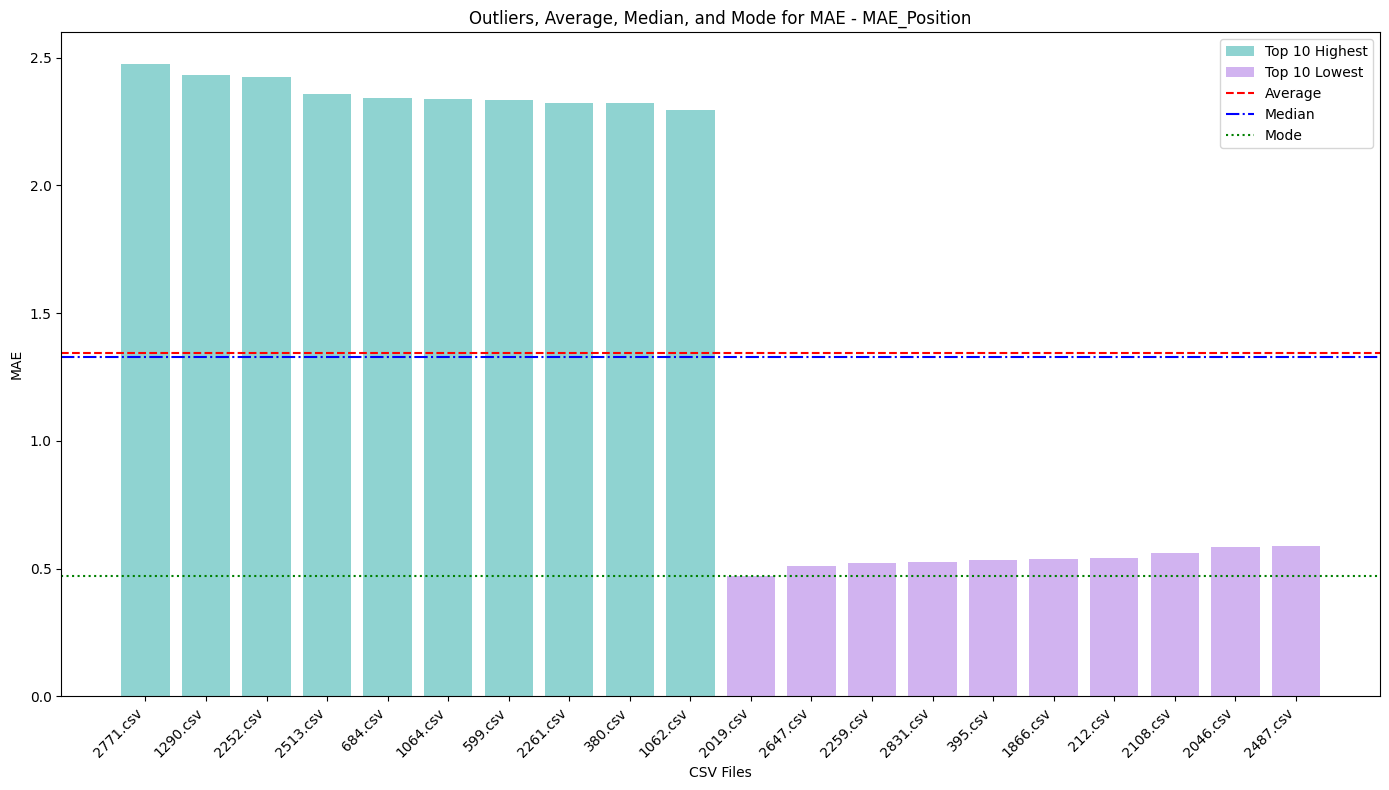


Processing Outliers, Average, Median, and Mode for MAE_Rotation


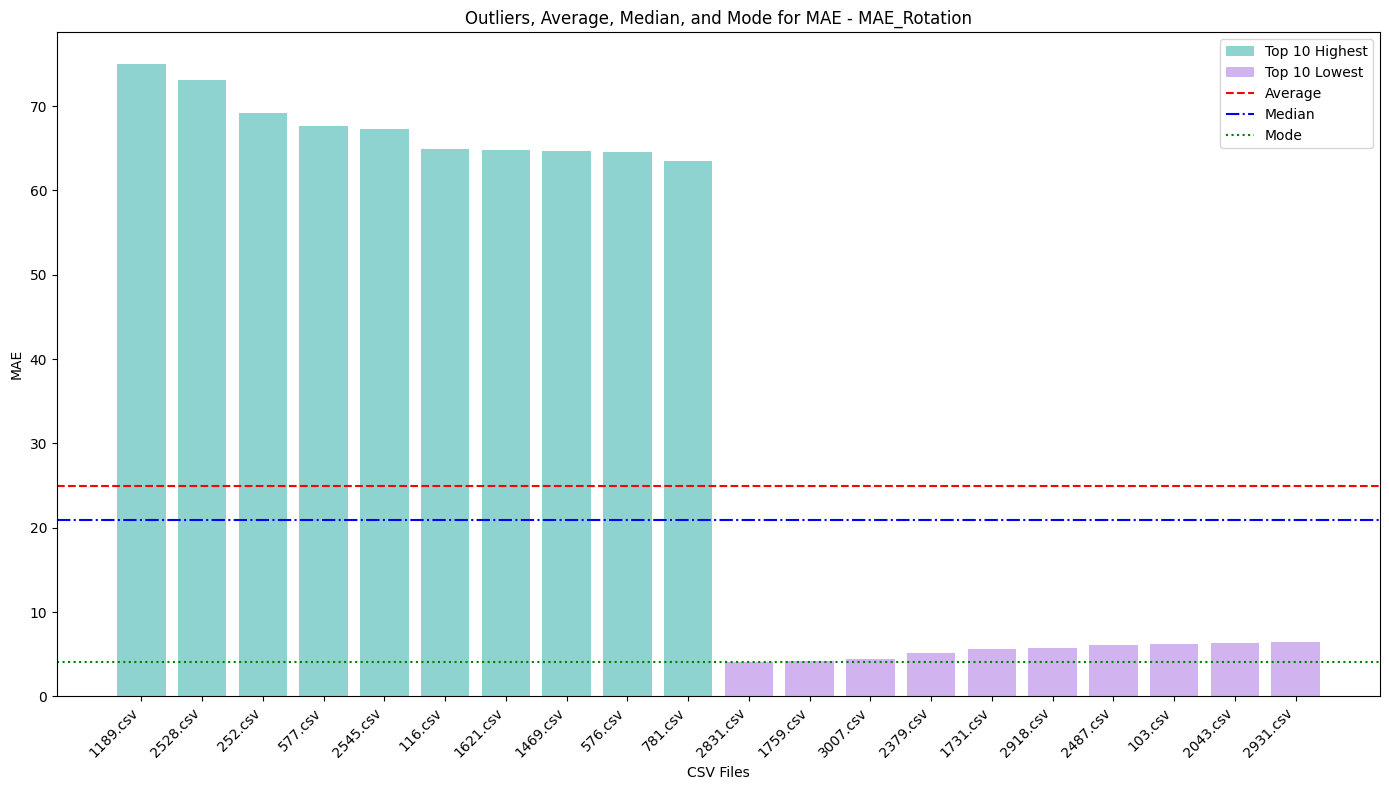


Processing Outliers, Average, Median, and Mode for MAE_Corners


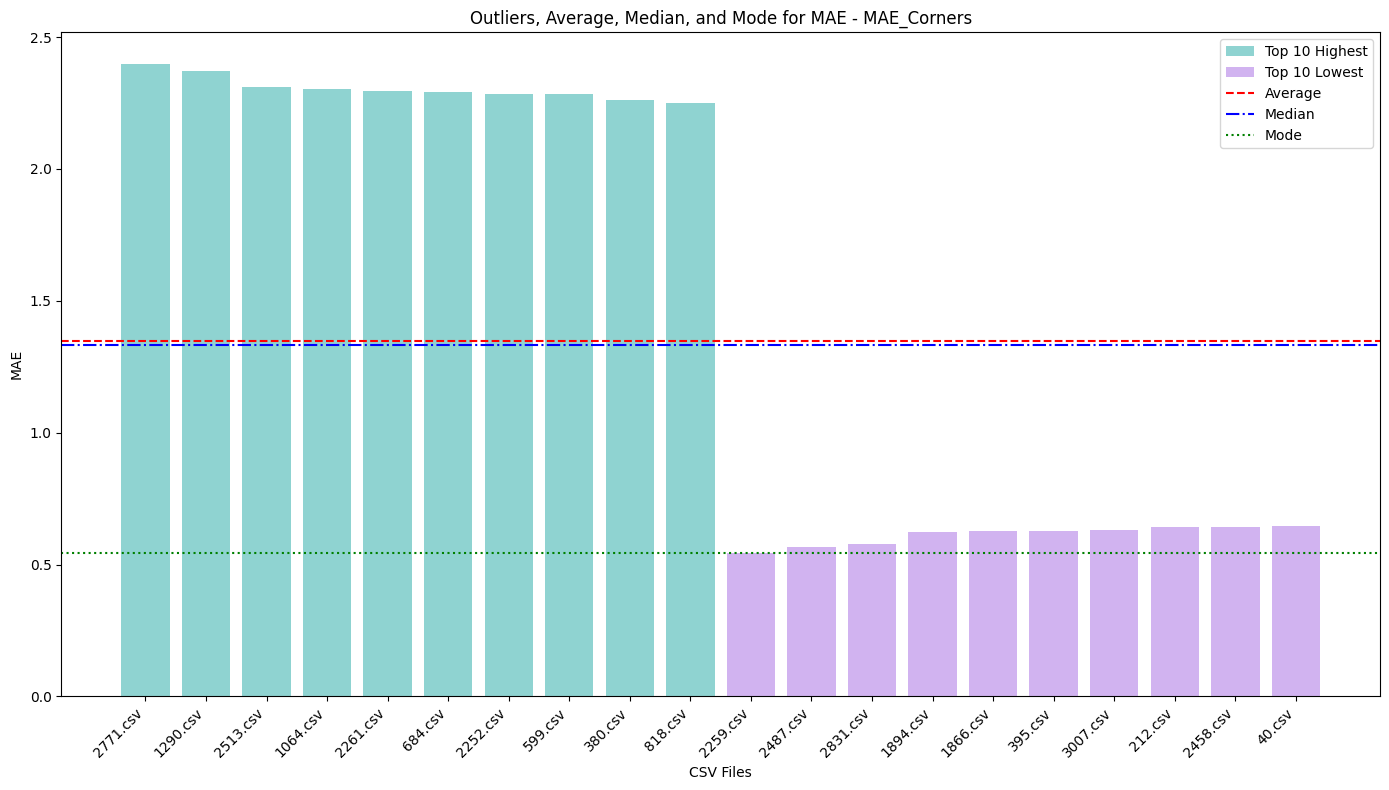


Processing Outliers, Average, Median, and Mode for MAE_Total


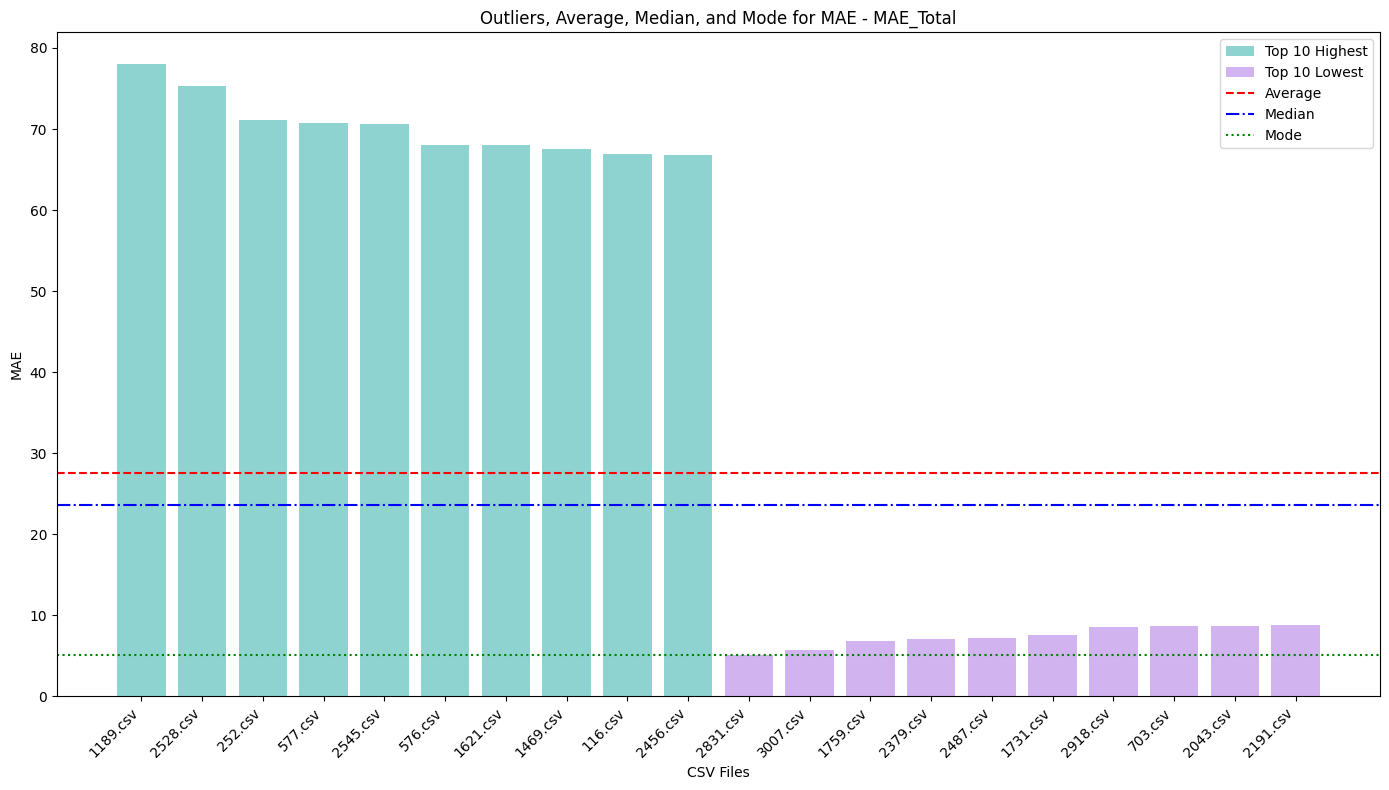


Processing Outliers, Average, Median, and Mode for RMSE_Position


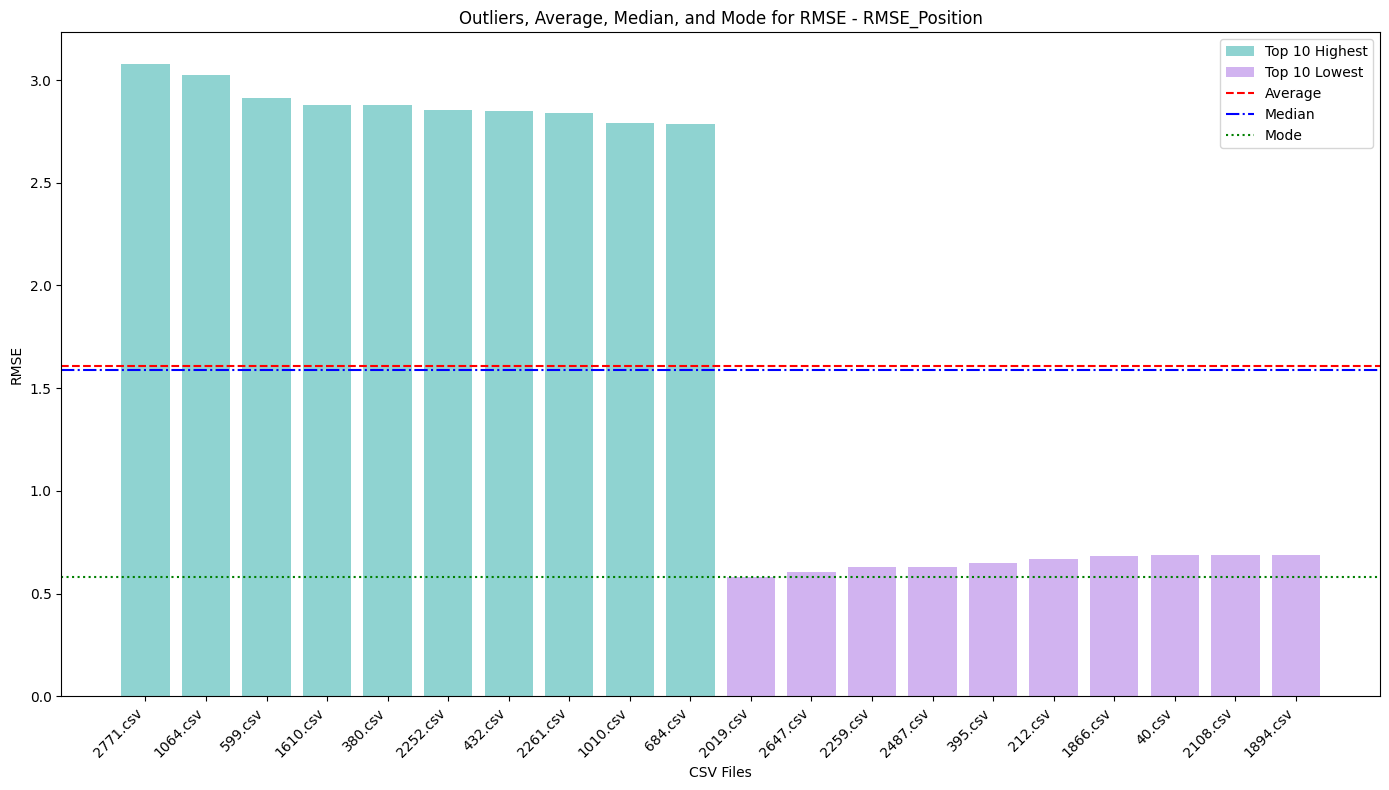


Processing Outliers, Average, Median, and Mode for RMSE_Rotation


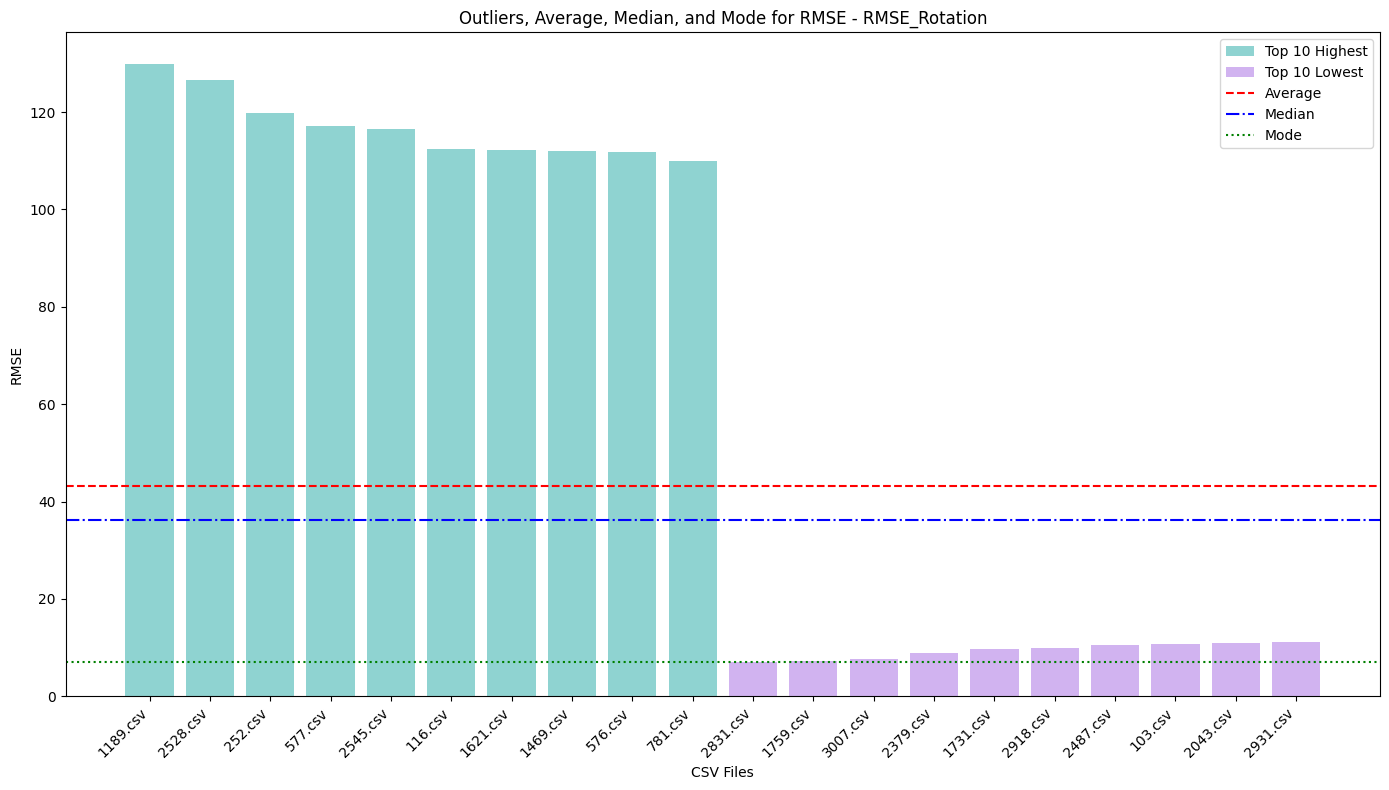


Processing Outliers, Average, Median, and Mode for RMSE_Corners


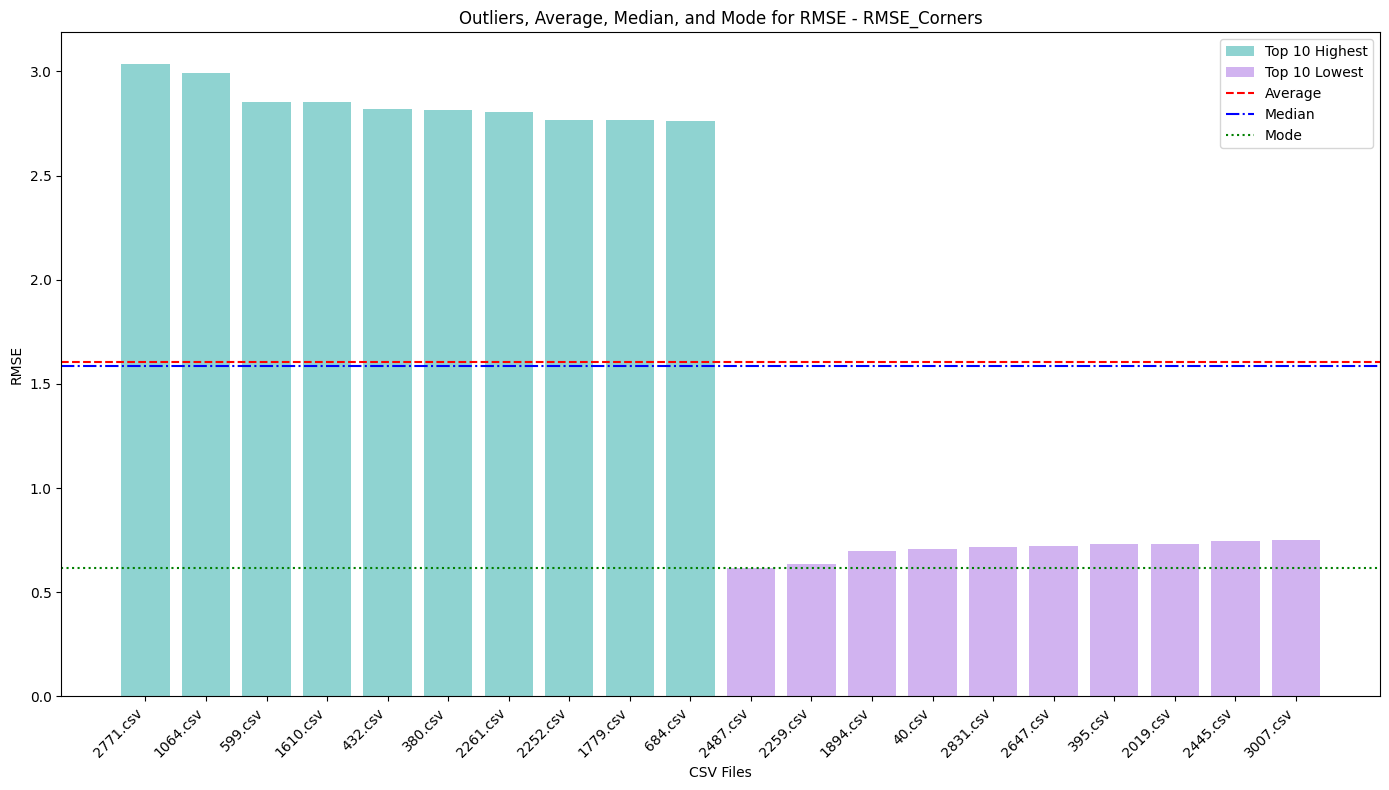


Processing Outliers, Average, Median, and Mode for RMSE_Total


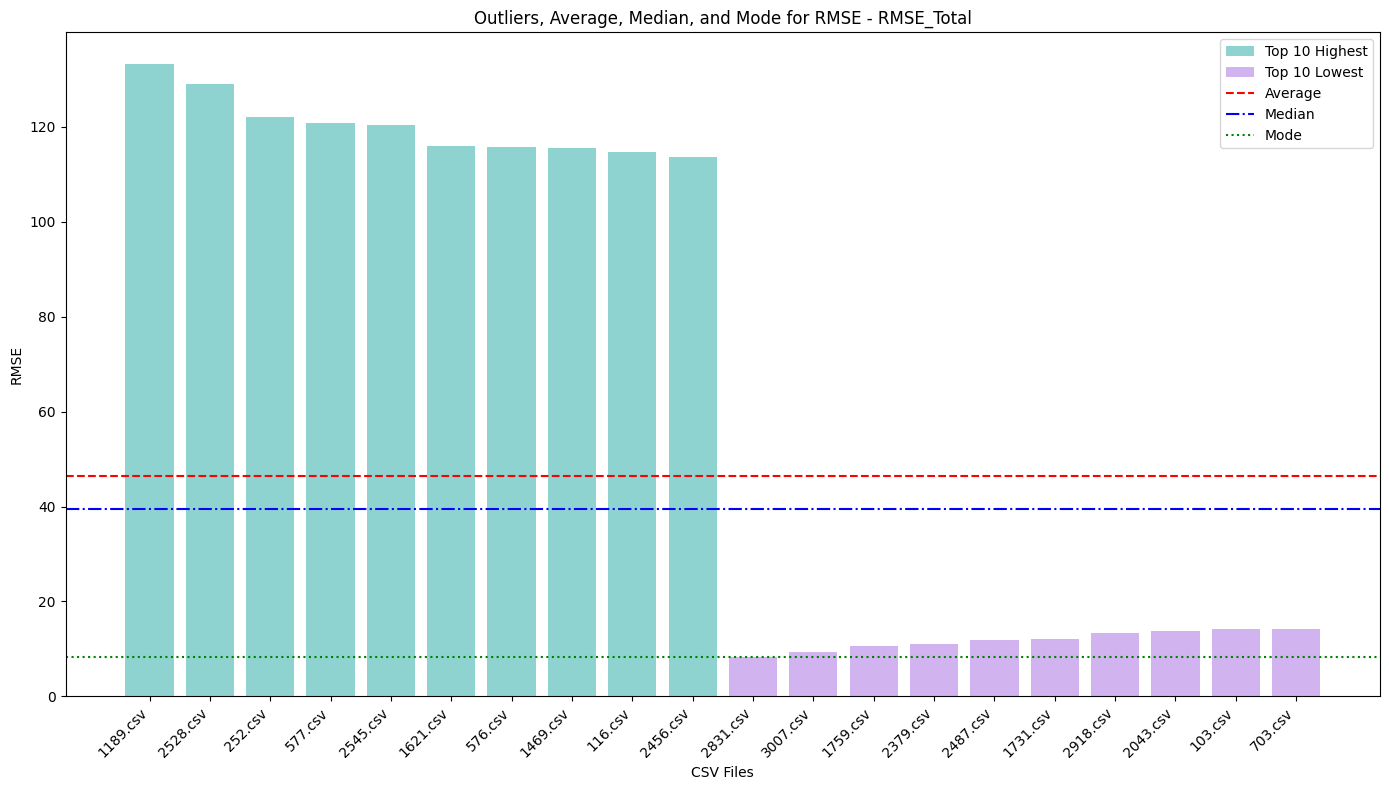

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to identify outliers, median, average, and mode
def identify_statistics(errors, category):
    data = []
    for file_name, metrics in errors.items():
        rmse = metrics["RMSE"]
        mae = metrics["MAE"]
        data.append([
            file_name,
            rmse["position"], rmse["rotation"], rmse["corners"],
            mae["position"], mae["rotation"], mae["corners"],
            rmse["position"] + rmse["rotation"] + rmse["corners"],  # Total RMSE
            mae["position"] + mae["rotation"] + mae["corners"],    # Total MAE
        ])
    
    columns = ["File", "RMSE_Position", "RMSE_Rotation", "RMSE_Corners",
               "MAE_Position", "MAE_Rotation", "MAE_Corners",
               "RMSE_Total", "MAE_Total"]
    df = pd.DataFrame(data, columns=columns)

    # Calculate statistics
    top_10_highest = df.nlargest(10, category)
    top_10_lowest = df.nsmallest(10, category)
    median_value = df[category].median()
    avg_value = df[category].mean()
    mode_value = df[category].mode().iloc[0]  # Mode can return multiple values; take the first

    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Function to visualize outliers, average, median, and mode
def visualize_statistics(top_10_high, top_10_low, category, metric_name, avg_value, median_value, mode_value):
    # Combine high and low into a single DataFrame for plotting
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[category]

    # Colors: Orange for highest, Skyblue for lowest
    colors = (
        ['#8fd3d1'] * len(top_10_high) +
        ['#d1b3f0'] * len(top_10_low)
    )

    # Bar Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(labels, values, color=colors)

    # Plot average as a red dotted line
    plt.axhline(avg_value, color='red', linestyle='--', linewidth=1.5, label=f'Average ({avg_value:.2f})')

    # Plot median as a blue dashed line
    plt.axhline(median_value, color='blue', linestyle='-.', linewidth=1.5, label=f'Median ({median_value:.2f})')

    # Plot mode as a green dotted line
    plt.axhline(mode_value, color='green', linestyle=':', linewidth=1.5, label=f'Mode ({mode_value:.2f})')

    # Create a custom legend
    legend_handles = [
        bars[0],  # Example bar for highest (teal)
        bars[-1],  # Example bar for lowest (purple)
    ]
    legend_labels = ["Top 10 Highest", "Top 10 Lowest"]

    # Plot customization
    plt.xlabel("CSV Files")
    plt.ylabel(metric_name)
    plt.title(f"Outliers, Average, Median, and Mode for {metric_name} - {category}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(legend_handles + [
        plt.Line2D([], [], color='red', linestyle='--'),
        plt.Line2D([], [], color='blue', linestyle='-.'),
        plt.Line2D([], [], color='green', linestyle=':'),
    ], legend_labels + ["Average", "Median", "Mode"])
    plt.show()

# Loop through all error categories including totals and generate plots
categories = [
    "MAE_Position", "MAE_Rotation", "MAE_Corners", "MAE_Total",
    "RMSE_Position", "RMSE_Rotation", "RMSE_Corners", "RMSE_Total"
]

for category in categories:
    metric_name = "MAE" if "MAE" in category else "RMSE"
    print(f"\nProcessing Outliers, Average, Median, and Mode for {category}")
    
    # Identify statistics
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics(errors, category)
    
    # Visualize statistics
    visualize_statistics(top_10_high, top_10_low, category, metric_name, avg_value, median_value, mode_value)


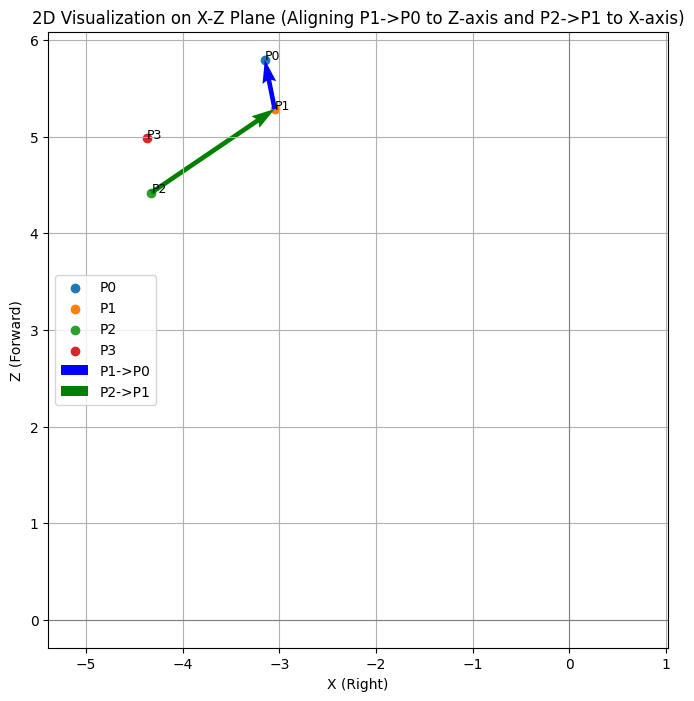

Vector P1->P0: [-0.1023  0.51  ]
Rotation Angle (radians) to align P1->P0 with Z-axis: -0.1979611066734218
Rotation Angle (degrees) to align P1->P0 with Z-axis: -11.342335920126144
Vector P2->P1: [1.2775 0.8665]
Rotation Angle (radians) to align P2->P1 with X-axis: -0.5959981208822565
Rotation Angle (degrees) to align P2->P1 with X-axis: -34.14817692428115


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Input coordinates (X and Z components)
points_xz = np.array([
    [-3.1509, 5.7967],  # P0
    [-3.0486, 5.2867],  # P1
    [-4.3261, 4.4202],  # P2
    [-4.3691, 4.9874]   # P3
])

# Calculate the vectors
vec_p1_p0 = points_xz[0] - points_xz[1]  # P1->P0
vec_p2_p1 = points_xz[1] - points_xz[2]  # P2->P1

# Function to calculate angle with a given axis
def calculate_angle(vector, axis):
    cos_theta = np.dot(vector, axis) / np.linalg.norm(vector)  # Cosine of the angle
    angle_radians = np.arccos(cos_theta)  # Angle in radians
    # Determine the direction of the angle (clockwise or counterclockwise)
    cross_product = vector[0] * axis[1] - vector[1] * axis[0]  # 2D cross product scalar
    if cross_product < 0:  # Negative cross product means clockwise
        angle_radians = -angle_radians
    return angle_radians

# Calculate angles
z_axis = np.array([0, 1])  # Z-axis in the X-Z plane
x_axis = np.array([1, 0])  # X-axis in the X-Z plane

angle_radians_p1_p0 = calculate_angle(vec_p1_p0, z_axis)  # Align P1->P0 with Z-axis
angle_radians_p2_p1 = calculate_angle(vec_p2_p1, x_axis)  # Align P2->P1 with X-axis

# Visualization
plt.figure(figsize=(8, 8))

# Plot the points
for i, point in enumerate(points_xz):
    plt.scatter(point[0], point[1], label=f"P{i}")
    plt.text(point[0], point[1], f"P{i}", fontsize=9)

# Plot the vectors
plt.quiver(points_xz[1, 0], points_xz[1, 1], vec_p1_p0[0], vec_p1_p0[1], angles='xy', scale_units='xy', scale=1, color='b', label="P1->P0")
plt.quiver(points_xz[2, 0], points_xz[2, 1], vec_p2_p1[0], vec_p2_p1[1], angles='xy', scale_units='xy', scale=1, color='g', label="P2->P1")

# Add axis lines
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)

# Set labels and title
plt.xlabel("X (Right)")
plt.ylabel("Z (Forward)")
plt.title("2D Visualization on X-Z Plane (Aligning P1->P0 to Z-axis and P2->P1 to X-axis)")
plt.legend()
plt.grid()
plt.axis('equal')  # Keep proportions equal
plt.show()

# Print results
print("Vector P1->P0:", vec_p1_p0)
print("Rotation Angle (radians) to align P1->P0 with Z-axis:", angle_radians_p1_p0)
print("Rotation Angle (degrees) to align P1->P0 with Z-axis:", np.degrees(angle_radians_p1_p0))
print("Vector P2->P1:", vec_p2_p1)
print("Rotation Angle (radians) to align P2->P1 with X-axis:", angle_radians_p2_p1)
print("Rotation Angle (degrees) to align P2->P1 with X-axis:", np.degrees(angle_radians_p2_p1))
